# **Sentiment Based Product Recommendation System**

***Author: Aniruddha Bose***

Ebuss has captured a huge market share in many fields, and it sells the products in various categories such as household essentials, books, personal care products, medicines, cosmetic items, beauty products, electrical appliances, kitchen and dining products and health care products.
With the advancement in technology, it is imperative for Ebuss to grow quickly in the e-commerce market to become a major leader in the market because it has to compete with the likes of Amazon, Flipkart, etc., which are already market leaders.

A model needs to be built which will improve the recommendations provided to the users given their past reviews and ratings

**Major tasks that are needed to be performed:**

*   Data Sourcing and Sentiment analysis
    1. Data loading and cleaning
    2. Text preprocessing
    3. Exploratory data analysis (EDA)
    4. Feature extraction
    5. Model building using supervised learning
    6. Training a text classification model
    7. Model evluation and inference
*   Building a recommendation system
    1. User-based recommendation system
    2. Item-based recommendation system
*   Improving the recommendations using the sentiment analysis model
*   Deploying the end-to-end project with a user interface
    1. Flask framework - to create web applications to deploy machine learning models
    2. Heroku (PaaS) - to make the web application public 
    3. Features of UI
       - Take any of the existing usernames as input
       - Create a submit button to submit the username
       - Once the submit button is pressed, it should recommend 5 products based on the entered username.



## Importing the necessary libraries

In [ ]:
# utility packages
import os
import os.path
import numpy as np
import pandas as pd
import itertools
import gzip
from tqdm import tqdm
import pickle
import time

# graphics related packages
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from wordcloud import WordCloud

# nlp related packages
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# model metrics related packages
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from sklearn import metrics
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve 
from sklearn.metrics import classification_report
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.preprocessing import MinMaxScaler

#Packages of all classifiers
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

# to handle imbalance in dataset
from imblearn.over_sampling import SMOTE
from imblearn import over_sampling
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

from collections import Counter
from warnings import filterwarnings
filterwarnings('ignore')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


We have used Google Colab for this assignment. As a pre-requiste we need to mount the Google drive (attached to personal gmail account) where the source data files have been saved

In [ ]:
# Mount the Google Drive to Collaboratory
from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


*The path must be altered per the location of the source file before executing the code*

In [ ]:
# folder path & source filename
folderpath = "gdrive/My Drive/Colab Notebooks/Data-Source/Capstone/"
filename = 'sample30.csv'

In [ ]:
pd.show_versions()


INSTALLED VERSIONS
------------------
commit           : b5958ee1999e9aead1938c0bba2b674378807b3d
python           : 3.7.12.final.0
python-bits      : 64
OS               : Linux
OS-release       : 5.4.144+
Version          : #1 SMP Tue Dec 7 09:58:10 PST 2021
machine          : x86_64
processor        : x86_64
byteorder        : little
LC_ALL           : None
LANG             : en_US.UTF-8
LOCALE           : en_US.UTF-8

pandas           : 1.1.5
numpy            : 1.19.5
pytz             : 2018.9
dateutil         : 2.8.2
pip              : 21.1.3
setuptools       : 57.4.0
Cython           : 0.29.26
pytest           : 3.6.4
hypothesis       : None
sphinx           : 1.8.6
blosc            : None
feather          : 0.4.1
xlsxwriter       : None
lxml.etree       : 4.2.6
html5lib         : 1.0.1
pymysql          : None
psycopg2         : 2.7.6.1 (dt dec pq3 ext lo64)
jinja2           : 2.11.3
IPython          : 5.5.0
pandas_datareader: 0.9.0
bs4              : 4.6.3
bottleneck       : 1.

### Data loading and cleaning

In [ ]:
filepath = folderpath + filename
# Reading ratings & reviews
dfReviews = pd.read_csv(filepath)
print("Dataframe Shape:", dfReviews.shape)
dfReviews.head()

Dataframe Shape: (30000, 15)


,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,NaN,NaN,5,i love this album. it's very good. more to the...,Just Awesome,Los Angeles,NaN,joshua,Positive
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor. This review was collected as part...,Good,NaN,NaN,dorothy w,Positive
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor.,Good,NaN,NaN,dorothy w,Positive
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,False,False,1,I read through the reviews on here before look...,Disappointed,NaN,NaN,rebecca,Negative
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,False,False,1,My husband bought this gel for us. The gel cau...,Irritation,NaN,NaN,walker557,Negative


In [ ]:
#print the column names
for col in dfReviews.columns:
  print(col)

id
brand
categories
manufacturer
name
reviews_date
reviews_didPurchase
reviews_doRecommend
reviews_rating
reviews_text
reviews_title
reviews_userCity
reviews_userProvince
reviews_username
user_sentiment


For sentiment analysis most important attributes are reviews_rating, reviews_text and user_sentiment 

In [ ]:
# detailed information about the loaded data
dfReviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id                    30000 non-null  object
 1   brand                 30000 non-null  object
 2   categories            30000 non-null  object
 3   manufacturer          29859 non-null  object
 4   name                  30000 non-null  object
 5   reviews_date          29954 non-null  object
 6   reviews_didPurchase   15932 non-null  object
 7   reviews_doRecommend   27430 non-null  object
 8   reviews_rating        30000 non-null  int64 
 9   reviews_text          30000 non-null  object
 10  reviews_title         29810 non-null  object
 11  reviews_userCity      1929 non-null   object
 12  reviews_userProvince  170 non-null    object
 13  reviews_username      29937 non-null  object
 14  user_sentiment        29999 non-null  object
dtypes: int64(1), object(14)
memory usage

In [ ]:
#Assign new column names
dfReviews.rename(columns ={'reviews_date': 'r_date', 'reviews_didPurchase': 'didPurchase', 'reviews_doRecommend': 'doRecommend',  
                    'reviews_rating': 'rating', 'reviews_text': 'r_text','reviews_title': 'r_title','reviews_userCity': 'user_city', 
                    'reviews_userProvince': 'user_province', 'reviews_username': 'user_name', 
                    }, inplace = True)

dfReviews.head()

,id,brand,categories,manufacturer,name,r_date,didPurchase,doRecommend,rating,r_text,r_title,user_city,user_province,user_name,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,NaN,NaN,5,i love this album. it's very good. more to the...,Just Awesome,Los Angeles,NaN,joshua,Positive
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor. This review was collected as part...,Good,NaN,NaN,dorothy w,Positive
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor.,Good,NaN,NaN,dorothy w,Positive
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,False,False,1,I read through the reviews on here before look...,Disappointed,NaN,NaN,rebecca,Negative
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,False,False,1,My husband bought this gel for us. The gel cau...,Irritation,NaN,NaN,walker557,Negative


In [ ]:
# checking the null values
dfReviews.isnull().sum()

id                    0
brand                 0
categories            0
manufacturer        141
name                  0
r_date               46
didPurchase       14068
doRecommend        2570
rating                0
r_text                0
r_title             190
user_city         28071
user_province     29830
user_name            63
user_sentiment        1
dtype: int64

In [ ]:
# Reviewing the values of "didPurchase" attribute
nanVal = dfReviews['didPurchase'].isnull().sum()
print("Number of users who have not purchase the product:", nanVal)

print("Nearly", round(nanVal/dfReviews.shape[0] * 100, 2), "% of records don't have value")

Number of users who have not purchase the product: 14068
Nearly 46.89 % of records don't have value


In [ ]:
# Reviewing the values of "doRecommend" attribute
nanVal = dfReviews['doRecommend'].isnull().sum()
print("Number of users who have not recommend the product:", nanVal)

print("Nearly", round(nanVal/dfReviews.shape[0] * 100, 2), "% of records don't have value")

Number of users who have not recommend the product: 2570
Nearly 8.57 % of records don't have value


In [ ]:
# Reviewing the values of "user_city" attribute
nanVal = dfReviews['user_city'].isnull().sum()
print("Number of users who didn't specify residing city:", nanVal)

print("Nearly", round(nanVal/dfReviews.shape[0] * 100, 2), "% of records don't have value")

Number of users who didn't specify residing city: 28071
Nearly 93.57 % of records don't have value


In [ ]:
# Reviewing the values of "user_province" attribute
nanVal = dfReviews['user_province'].isnull().sum()
print("Number of users who didn't specify residing province:", nanVal)

print("Nearly", round(nanVal/dfReviews.shape[0] * 100, 2), "% of records don't have value")

Number of users who didn't specify residing province: 29830
Nearly 99.43 % of records don't have value


In [ ]:
# checking duplicate records
duplicate = dfReviews[dfReviews.duplicated()]
len(duplicate)

0

Currently, there is no duplicate records...

Clearly columns like "manufacturer", "didPurchase", "doRecommend", "user_city", "user_province" and "r_date" are not very useful for our analyis. Hence, we decided to drop them.

In [ ]:
# Remove the above said columns
dfReviews.drop(['didPurchase', 'doRecommend', 'user_city', 'user_province', 'r_date', 'manufacturer'], axis = 1, inplace = True)

dfReviews.shape

(30000, 9)

In [ ]:
# checking the null values
dfReviews.isnull().sum()

id                  0
brand               0
categories          0
name                0
rating              0
r_text              0
r_title           190
user_name          63
user_sentiment      1
dtype: int64

user_name is an important attribute for user's sentiment based recommendation hence decided to remove those records where user_name is null

In [ ]:
# dropping records having null user_name
dfReviews = dfReviews.dropna(subset=['user_name'])
dfReviews.shape

(29937, 9)

In [ ]:
# checking the null values
dfReviews.isnull().sum()

id                  0
brand               0
categories          0
name                0
rating              0
r_text              0
r_title           189
user_name           0
user_sentiment      1
dtype: int64

**We observed that 1 value is missing in user_sentiment. Now we will try to find out distribution of user sentiment w.r.t rating.**

Count distribution of rating



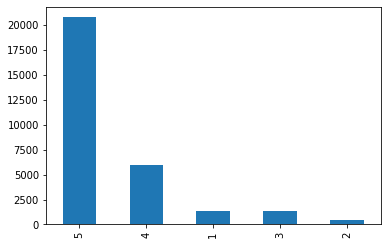

In [ ]:
print("Count distribution of rating\n") 
dfReviews["rating"].value_counts().plot.bar()

Count distribution of user sentiment



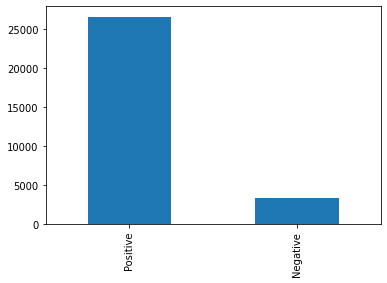

In [ ]:
print("Count distribution of user sentiment\n") 
dfReviews["user_sentiment"].value_counts().plot.bar()

In [ ]:
# Stacked Bar Chart visualization
def show_stacked_barchart(var, target, xlabel, ylabel, title, color, legend, rotation):
    groupVal = dfReviews.groupby([var, target])[var].count().unstack()
    p1 = groupVal.plot(kind = 'bar', stacked = True, 
                   title = title, 
                   color = color)
    p1.set_xlabel(xlabel)
    p1.set_ylabel(ylabel)
    plt.setp(p1.get_xticklabels(), rotation=rotation, rotation_mode="anchor")
    p1.legend(legend)

<Figure size 1080x360 with 0 Axes>

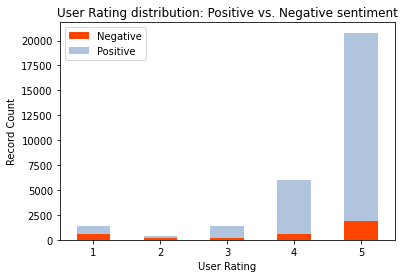

In [ ]:
plt.figure(figsize=(15,5))

title = "User Rating distribution: Positive vs. Negative sentiment"
legend = ['Negative','Positive']
color = ['orangered','lightsteelblue']
rotation = 0

var = "rating"
target = "user_sentiment"
ylabel = "Record Count"
xlabel = "User Rating"
show_stacked_barchart(var, target, xlabel, ylabel, title, color, legend, rotation)

In [ ]:
print("Rating 1 sentiment distribution")
print(dfReviews[dfReviews["rating"] == 1]["user_sentiment"].value_counts())

print("\nRating 2 sentiment distribution")
print(dfReviews[dfReviews["rating"] == 2]["user_sentiment"].value_counts())

print("\nRating 3 sentiment distribution")
print(dfReviews[dfReviews["rating"] == 3]["user_sentiment"].value_counts())

print("\nRating 4 sentiment distribution")
print(dfReviews[dfReviews["rating"] == 4]["user_sentiment"].value_counts())

print("\nRating 5 sentiment distribution")
print(dfReviews[dfReviews["rating"] == 5]["user_sentiment"].value_counts())

Rating 1 sentiment distribution
Positive    780
Negative    593
Name: user_sentiment, dtype: int64

Rating 2 sentiment distribution
Positive    278
Negative    140
Name: user_sentiment, dtype: int64

Rating 3 sentiment distribution
Positive    1125
Negative     219
Name: user_sentiment, dtype: int64

Rating 4 sentiment distribution
Positive    5460
Negative     550
Name: user_sentiment, dtype: int64

Rating 5 sentiment distribution
Positive    18936
Negative     1855
Name: user_sentiment, dtype: int64


From the above chart it is very clear that from Rating 3 onwards the majority of user's sentiment is positive however we observed some exceptions. Ideally for rating 1 and 2 we expect negative sentiment but there are also considerable number of positive sentiments.

*Working on missing sentiment record...*

In [ ]:
dfReviews[dfReviews["user_sentiment"].isnull()]

,id,brand,categories,name,rating,r_text,r_title,user_name,user_sentiment
28354,AVpfRTh1ilAPnD_xYic2,Disney,"Movies, Music & Books,Movies,Kids' & Family,Wa...",Planes: Fire Rescue (2 Discs) (includes Digita...,5,my kids absolutely loved this film so much tha...,a super hit with my children. they loved it!!??,7.87E+11,NaN


In [ ]:
# Rating is 5 and review text has positive vibe, hence updating the sentiment with the value "Positive"
dfReviews.loc[dfReviews["user_sentiment"].isnull(),"user_sentiment"] = "Positive"

dfReviews[dfReviews["user_name"] == "7.87E+11"]

,id,brand,categories,name,rating,r_text,r_title,user_name,user_sentiment
27254,AVpfRTh1ilAPnD_xYic2,Disney,"Movies, Music & Books,Movies,Kids' & Family,Wa...",Planes: Fire Rescue (2 Discs) (includes Digita...,3,I watched the movie from beginning to end. It ...,NaN,7.87E+11,Positive
28354,AVpfRTh1ilAPnD_xYic2,Disney,"Movies, Music & Books,Movies,Kids' & Family,Wa...",Planes: Fire Rescue (2 Discs) (includes Digita...,5,my kids absolutely loved this film so much tha...,a super hit with my children. they loved it!!??,7.87E+11,Positive


In [ ]:
# checking the null values
dfReviews.isnull().sum()

id                  0
brand               0
categories          0
name                0
rating              0
r_text              0
r_title           189
user_name           0
user_sentiment      0
dtype: int64

*Now, there is no record with missing user sentiment.*

In [ ]:
# re-checking duplicate records
duplicate = dfReviews[dfReviews.duplicated()]
len(duplicate)

279

In [ ]:
duplicate.head()

,id,brand,categories,name,rating,r_text,r_title,user_name,user_sentiment
299,AV1l8zRZvKc47QAVhnAv,Olay,"Personal Care,Skin Care,Anti-Aging,Beauty,Face...",Olay Regenerist Deep Hydration Regenerating Cream,5,I loved this product. My skin was so soft and ...,Regenerating Cream,cindy95,Positive
770,AV1YGDqsGV-KLJ3adc-O,Windex,"Household Essentials,Cleaning Supplies,Glass C...",Windex Original Glass Cleaner Refill 67.6oz (2...,4,I carry this around with me everywhere I go wh...,My Go-To Cleaner,prolsbe,Positive
931,AV1YGDqsGV-KLJ3adc-O,Windex,"Household Essentials,Cleaning Supplies,Glass C...",Windex Original Glass Cleaner Refill 67.6oz (2...,5,Windex Original is the only glass cleaner I've...,Best,arkydoodlebug,Positive
4477,AVpe9W4D1cnluZ0-avf0,Hoover,"Home,Home Appliances,Vacuums & Floor Care,Upri...",Hoover174 Platinum Collection153 Lightweight B...,5,WOW! I got mine from ... today and all I can s...,A++++++++++,ginab,Positive
6503,AVpf3VOfilAPnD_xjpun,Clorox,"Household Essentials,Cleaning Supplies,Kitchen...",Clorox Disinfecting Wipes Value Pack Scented 1...,2,I wouldn't trust any other brand when it comes...,Great Product,jackndbox,Negative


In [ ]:
# checking few instances to understand duplicate records in the dataset 
dfReviews[(dfReviews["id"] == "AV1l8zRZvKc47QAVhnAv") & (dfReviews["user_name"] == "cindy95")]

,id,brand,categories,name,rating,r_text,r_title,user_name,user_sentiment
192,AV1l8zRZvKc47QAVhnAv,Olay,"Personal Care,Skin Care,Anti-Aging,Beauty,Face...",Olay Regenerist Deep Hydration Regenerating Cream,5,I loved this product. My skin was so soft and ...,Regenerating Cream,cindy95,Positive
299,AV1l8zRZvKc47QAVhnAv,Olay,"Personal Care,Skin Care,Anti-Aging,Beauty,Face...",Olay Regenerist Deep Hydration Regenerating Cream,5,I loved this product. My skin was so soft and ...,Regenerating Cream,cindy95,Positive
444,AV1l8zRZvKc47QAVhnAv,Olay,"Personal Care,Skin Care,Anti-Aging,Beauty,Face...",Olay Regenerist Deep Hydration Regenerating Cream,5,Great product. Made my skin smooth and creamy....,Love it.,cindy95,Positive


In [ ]:
# Removing duplicate records. keep = ‘first’: it considers first value as unique and rest of the same values as duplicate
dfReviews.drop_duplicates(keep = 'first', inplace = True)
duplicate = dfReviews[dfReviews.duplicated()]
print("Number of duplicate records:", len(duplicate))
print("Remaining records after removing duplicates:", len(dfReviews))

Number of duplicate records: 0
Remaining records after removing duplicates: 29658


In [ ]:
# Storing the original data
dfReviews_ori = dfReviews.copy()
dfReviews_ori.shape

(29658, 9)

In [ ]:
# random manual verification of user sentiment corresponds to user review 
dfReviews[dfReviews["rating"] == 4][["r_text", "user_sentiment"]].head(50)

,r_text,user_sentiment
20,I noticed this product on clearance at a store...,Positive
21,I used this product a couple of times since i ...,Positive
22,Used a few times stays a bit sticky but not to...,Positive
36,Not sure how this works with clearing your com...,Positive
43,"Well, Johnson's need I say more I know, right....",Positive
44,"Well, Johnson's need I say more I know, right....",Positive
45,"The bubbles aren't over the top fabulous, but ...",Positive
46,I ma using this for my baby when she is one mo...,Positive
47,Lots of fun in the bath but have to use a lot ...,Positive
91,Its keeps your face feeling moisturizer and so...,Positive


What we observed sentiment is quite consistent with review text however the user rating may not always able to depict the sentiment clearly. For example:

 - "*This is a great windex product that I came across after a long time.Please try once and then believe me.*" has positive sense and it is rightly classified as "Positive" sentiment however the rating is just 2 for this product.

There is reverse example as well
 - "*This product has made my skin smoother and supple after only two weeks. It absorbs well and leaves no residue.*" has postive sense with rating 4 but it is classified as "Negative" sentiment 

### Data preprocessing

We are assuming "user rating" as ground truth and will alter the "user sentiment" as applicable which is the target variable for the sentiment analysis model. We would like to make the rating consistent along with the sentiment so that the other model recommendation engine works in tandem with the sentiment analysis model.

Rules set for data correction are:
 - If rating of a product is 1 or 2, the expected user sentiment is "Negative"
 - If rating of a product is 4 or 5, the expected user sentiment is "Positive"
 - If rating of a product is 3 we may not expect strong positive or negative feedback. The sentiment in most cases brings mix feeling after going through the review text; hence decided to drop those records where the products are rated with 3.

In [ ]:
# revising the user rating on the basis of user sentiment
def alter_rating(df):
  new_rating = df["rating"]
  if (((df["rating"] == 1) or (df["rating"] == 2)) and (df["user_sentiment"] == "Positive")):
    new_rating = 4
  if (((df["rating"] == 4) or (df['rating'] == 5)) and (df["user_sentiment"] == "Negative")):
    new_rating = 2

  return new_rating

In [ ]:
dfReviews['revised_sentiment'] = dfReviews["rating"].apply(lambda x: "Positive" if x > 3 else "Negative")
dfReviews.head(20)

,id,brand,categories,name,rating,r_text,r_title,user_name,user_sentiment,revised_sentiment
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Pink Friday: Roman Reloaded Re-Up (w/dvd),5,i love this album. it's very good. more to the...,Just Awesome,joshua,Positive,Positive
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg Organic Cinnamon Toast Rice Cakes,5,Good flavor. This review was collected as part...,Good,dorothy w,Positive,Positive
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg Organic Cinnamon Toast Rice Cakes,5,Good flavor.,Good,dorothy w,Positive,Positive
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y Love Sensuality Pleasure Gel,1,I read through the reviews on here before look...,Disappointed,rebecca,Negative,Negative
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y Love Sensuality Pleasure Gel,1,My husband bought this gel for us. The gel cau...,Irritation,walker557,Negative,Negative
5,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y Love Sensuality Pleasure Gel,1,My boyfriend and I bought this to spice things...,Not worth it,samantha,Negative,Negative
6,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y Love Sensuality Pleasure Gel,1,Bought this earlier today and was excited to c...,Disappointing,raeanne,Negative,Negative
7,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y Love Sensuality Pleasure Gel,1,I bought this product for my husband and I to ...,Not happy at all,kimmie,Negative,Negative
8,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y Love Sensuality Pleasure Gel,1,My husband and I bought this for some extra fu...,Very disappointing,cassie,Negative,Negative
9,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y Love Sensuality Pleasure Gel,1,Got as a surprise for my husband there is noth...,Don't buy,moore222,Positive,Negative


In [ ]:
dfReviews.shape

(29658, 10)

In [ ]:
# Drop the records where product rating is 3
dfReviews = dfReviews[dfReviews["rating"] != 3]
dfReviews.shape

(28330, 10)

<Figure size 1080x360 with 0 Axes>

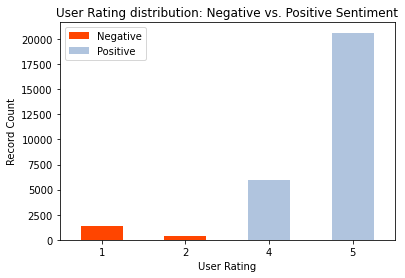

In [ ]:
plt.figure(figsize=(15,5))

title = "User Rating distribution: Negative vs. Positive Sentiment"
legend = ['Negative','Positive']
color = ['orangered','lightsteelblue']
rotation = 0

var = "rating"
target = "revised_sentiment"
ylabel = "Record Count"
xlabel = "User Rating"
show_stacked_barchart(var, target, xlabel, ylabel, title, color, legend, rotation)

**Now the dataset is clearly depicting that a product with higher rating has positive sentiment and a product with lower rating has negative sentiment. Now product rating is very much consistent with user sentiment.**

## Sentiment Analysis

In [ ]:
# Inspecting the text of a single complain minutely, so that appropriate corrections can be applied
dfReviews["r_text"].iloc[20000]

'This stove drafts VERY well ... after my inital install I had to take it apart & put in a Flue Damper because She\'s a heavy breather ... I even partly blocked the bottom primary 1/2 " air hole with steel wool (just to be able to have more control 4 over nite burns) when fully loaded w/o damper & hole blockage easily got 700 + stove top Temps.Now will cruise 600 ish Great secondary Burn & nice wide firebox.It\'s a really nice stove well worth having, though a damper is recommended !!!'

In [ ]:
# a function to clean the text and remove all the unnecessary elements.
def clean_text(text):
  replacement = ' '
  # convert into lower case
  text = text.lower()
  #pattern = re.compile('\w.')
  #text = re.sub(pattern, replacement, text)
  # remove brackets and other punctuations
  pattern = re.compile('[^\w\s]')
  text = re.sub(pattern, replacement, text)
  # remove numbers
  pattern = re.compile('[0-9]')
  text = re.sub(pattern, replacement, text)

  # find 1 or more space and replace with a space  
  pattern = re.compile('\s+')
  text = re.sub(pattern, replacement, text)

  #remove whitespace Left & Right trim
  text = text.strip()

  return text

In [ ]:
# Test the clean_text function
print(dfReviews['r_text'].iloc[20000])
print("\nCleaned Text:")
print(clean_text(dfReviews['r_text'].iloc[20000]))

This stove drafts VERY well ... after my inital install I had to take it apart & put in a Flue Damper because She's a heavy breather ... I even partly blocked the bottom primary 1/2 " air hole with steel wool (just to be able to have more control 4 over nite burns) when fully loaded w/o damper & hole blockage easily got 700 + stove top Temps.Now will cruise 600 ish Great secondary Burn & nice wide firebox.It's a really nice stove well worth having, though a damper is recommended !!!

Cleaned Text:
this stove drafts very well after my inital install i had to take it apart put in a flue damper because she s a heavy breather i even partly blocked the bottom primary air hole with steel wool just to be able to have more control over nite burns when fully loaded w o damper hole blockage easily got stove top temps now will cruise ish great secondary burn nice wide firebox it s a really nice stove well worth having though a damper is recommended


In [ ]:
# initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

In [ ]:
# function to return appropriate pos tag
def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

In [ ]:
#function to Lemmatize the texts
def lemma_text(sentence):
    sentence = clean_text(sentence)
    #tokenize the sentence and find the POS tag for each token
    nltk_tagged = nltk.pos_tag(nltk.word_tokenize(sentence))
    #tuple of (token, wordnet_tag)
    wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)
    lemmatized_sentence = []
    for token, tag in wordnet_tagged:
      # here token length less than 3 characters is not considered
      if len(token) < 3 or token in set(stopwords.words('english')):
        continue
      if tag is None:
        #if there is no available tag, append the token as is
        lemmatized_sentence.append(token)
      else:
        #else use the tag to lemmatize the token
        lemmatized_sentence.append(lemmatizer.lemmatize(token, tag))
    return " ".join(lemmatized_sentence)

In [ ]:
# Test the lemmatizer function
print(dfReviews['r_text'].iloc[20000])
print("\n\nLemmatize the text:")
print(lemma_text(dfReviews['r_text'].iloc[20000]))

This stove drafts VERY well ... after my inital install I had to take it apart & put in a Flue Damper because She's a heavy breather ... I even partly blocked the bottom primary 1/2 " air hole with steel wool (just to be able to have more control 4 over nite burns) when fully loaded w/o damper & hole blockage easily got 700 + stove top Temps.Now will cruise 600 ish Great secondary Burn & nice wide firebox.It's a really nice stove well worth having, though a damper is recommended !!!


Lemmatize the text:
stove draft well inital install take apart put flue damper heavy breather even partly block bottom primary air hole steel wool able control nite burn fully load damper hole blockage easily get stove top temp cruise ish great secondary burn nice wide firebox really nice stove well worth though damper recommend


In [ ]:
tqdm.pandas()
# lemmatization is computationally expensive process hence applied progress_apply of tqdm to monitor the progress
dfReviews['r_text_lemma'] = dfReviews['r_text'].progress_apply(lambda x: lemma_text(x))

100%|██████████| 28330/28330 [03:10<00:00, 149.10it/s]


In [ ]:
dfReviews.head(3)

,id,brand,categories,name,rating,r_text,r_title,user_name,user_sentiment,revised_sentiment,r_text_lemma
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Pink Friday: Roman Reloaded Re-Up (w/dvd),5,i love this album. it's very good. more to the...,Just Awesome,joshua,Positive,Positive,love album good hip hop side current pop sound...
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg Organic Cinnamon Toast Rice Cakes,5,Good flavor. This review was collected as part...,Good,dorothy w,Positive,Positive,good flavor review collect part promotion
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg Organic Cinnamon Toast Rice Cakes,5,Good flavor.,Good,dorothy w,Positive,Positive,good flavor


##### Mini-checkpoint: 1

In [ ]:
# Saving the dataframes into file for re-purpose
print(dfReviews.shape)
filepath = folderpath + 'review_major_col.csv'
dfReviews.to_csv(filepath, index=False)

(28330, 11)


In [ ]:
# Read the newly constructed csv file
filepath = folderpath + 'review_major_col.csv'
dfReviews = pd.read_csv(filepath)

print(dfReviews.shape)
dfReviews.head()

(28330, 11)


,id,brand,categories,name,rating,r_text,r_title,user_name,user_sentiment,revised_sentiment,r_text_lemma
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Pink Friday: Roman Reloaded Re-Up (w/dvd),5,i love this album. it's very good. more to the...,Just Awesome,joshua,Positive,Positive,love album good hip hop side current pop sound...
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg Organic Cinnamon Toast Rice Cakes,5,Good flavor. This review was collected as part...,Good,dorothy w,Positive,Positive,good flavor review collect part promotion
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg Organic Cinnamon Toast Rice Cakes,5,Good flavor.,Good,dorothy w,Positive,Positive,good flavor
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y Love Sensuality Pleasure Gel,1,I read through the reviews on here before look...,Disappointed,rebecca,Negative,Negative,read review look buy one couple lubricant ulti...
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y Love Sensuality Pleasure Gel,1,My husband bought this gel for us. The gel cau...,Irritation,walker557,Negative,Negative,husband buy gel gel cause irritation felt like...


### Exploratory Data Analysis

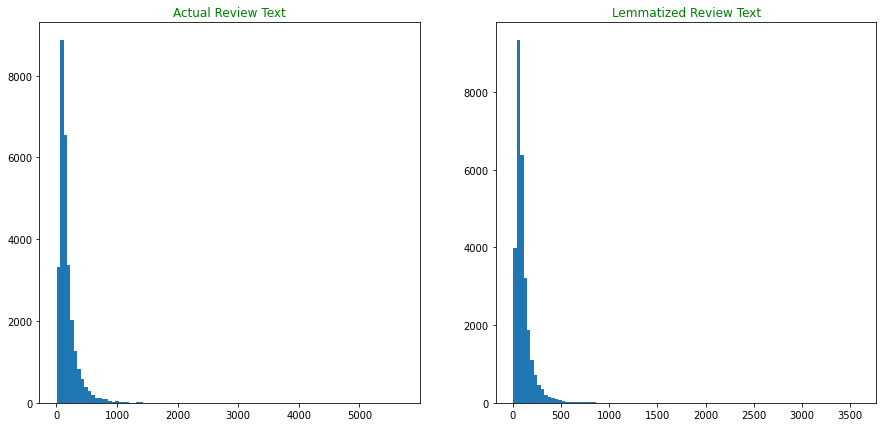

In [ ]:
# Visualise the data according to the 'Review' character length
fig = plt.figure(figsize=(15,7))

plt.subplot(1, 2, 1)
plt.title('Actual Review Text', fontsize=12, color = "Green")
doc_lens = [len(str(d)) for d in dfReviews.r_text]
plt.hist(doc_lens, bins = 100)
#plt.show()

plt.subplot(1, 2, 2)
plt.title('Lemmatized Review Text', fontsize=12, color = "Green")
doc_lens = [len(str(d)) for d in dfReviews.r_text_lemma]
plt.hist(doc_lens, bins = 100)
plt.show()

**Majority of the actual review text is below 1450 characters whereas lemmatized review text is below 850 characters**

#### Find the top 40 words by frequency among all the review text 

In [ ]:
#Using a word cloud find the top 40 words by frequency among all the review text
# Display Word Cloud 
def showWordCloud(max_words = 40):
  stoplist = set(stopwords.words("english"))
  plt.figure(figsize=(20,10))
  wc1 = WordCloud(stopwords=stoplist,background_color="white",width=1000,height=500, max_words=max_words,relative_scaling=0.5,normalize_plurals=False).generate(str(dfReviews.r_text))
  plt.subplot(1, 2, 1)
  plt.imshow(wc1)
  plt.axis('off')
  plt.title('Raw Tokens', fontsize=12, color = "Red")

  # Lemmatized tokens - it doesn't contain Stopwords
  wc2 = WordCloud(background_color="black",width=1000,height=500, max_words=max_words,relative_scaling=0.5,normalize_plurals=False).generate(str(dfReviews.r_text_lemma))
  plt.subplot(1, 2, 2)
  plt.imshow(wc2)
  plt.axis('off')
  plt.title('Lemmatized Tokens', fontsize=12, color = "Red")


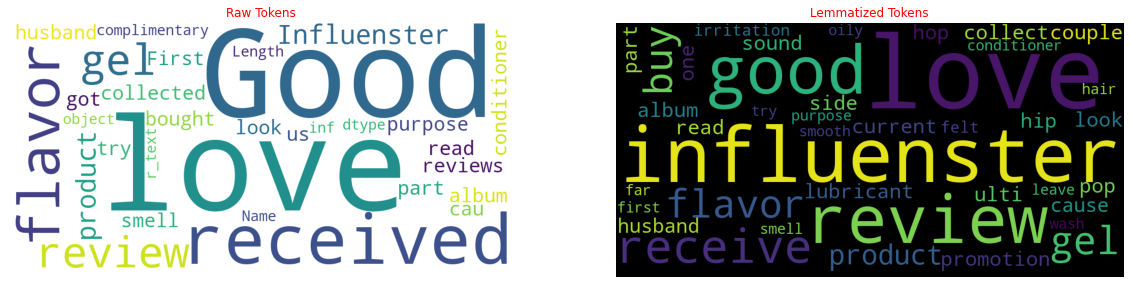

In [ ]:
# show word cloud
showWordCloud()

Most of the frequently occurring words are appeared to be same accross Raw and Lemmatized datasets. 

#### Find the top unigrams,bigrams and trigrams by frequency among all the user reviews after processing the text.

In [ ]:
#To find the top 30 unigram frequency among the user reviews in the cleaned datafram. 
def get_top_n_ngram(corpus, ngram = 1, n=None):
    vec = CountVectorizer(ngram_range=(ngram, ngram), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    #print(bag_of_words)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    #print(words_freq)
    return words_freq[:n]

In [ ]:
#Print the top 10 words in the unigram frequency
common_words = get_top_n_ngram(dfReviews["r_text_lemma"].fillna(' '), 1, 30)
df_unigram = pd.DataFrame(common_words, columns = ['Unigram' , 'Count'])
df_unigram.iloc[:10,:]

,Unigram,Count
0,use,12402
1,love,9591
2,product,8873
3,review,8834
4,great,8665
5,collect,8317
6,promotion,8298
7,movie,7028
8,clean,6886
9,wipe,6455


In [ ]:
#Print the top 10 words in the bigram frequency
common_words = get_top_n_ngram(dfReviews["r_text_lemma"].fillna(' '), 2, 30)
df_bigram = pd.DataFrame(common_words, columns = ['Bigram' , 'Count'])
df_bigram.iloc[:10,:]

,Bigram,Count
0,review collect,8295
1,collect promotion,8295
2,clorox wipe,1959
3,easy use,1315
4,use clorox,1039
5,use product,914
6,love clorox,909
7,love product,822
8,great product,810
9,great movie,666


In [ ]:
#Print the top 10 words in the trigram frequency
common_words = get_top_n_ngram(dfReviews["r_text_lemma"].fillna(' '), 3, 30)
df_trigram = pd.DataFrame(common_words, columns = ['Trigram' , 'Count'])
df_trigram.iloc[:10,:]

,Trigram,Count
0,review collect promotion,8295
1,use clorox wipe,529
2,love clorox wipe,450
3,clorox disinfect wipe,430
4,clean review collect,418
5,product review collect,415
6,use review collect,355
7,receive product free,240
8,love use clorox,219
9,wipe easy use,207


### Feature Extraction

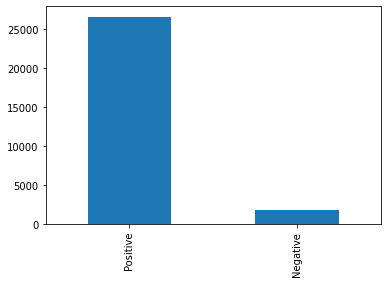

In [ ]:
# Distribution of Positive vs. Negative sentiment
dfReviews["revised_sentiment"].value_counts().plot(kind = "bar")

**Indeed imbalance data as far as target variable is concerned**

In [ ]:
# Adding a numeric column of sentiment
dfReviews["sentiment_class_num"] = dfReviews['revised_sentiment'].map({'Negative':0,'Positive':1})
dfReviews.head()

,id,brand,categories,name,rating,r_text,r_title,user_name,user_sentiment,revised_sentiment,r_text_lemma,sentiment_class_num
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Pink Friday: Roman Reloaded Re-Up (w/dvd),5,i love this album. it's very good. more to the...,Just Awesome,joshua,Positive,Positive,love album good hip hop side current pop sound...,1
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg Organic Cinnamon Toast Rice Cakes,5,Good flavor. This review was collected as part...,Good,dorothy w,Positive,Positive,good flavor review collect part promotion,1
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg Organic Cinnamon Toast Rice Cakes,5,Good flavor.,Good,dorothy w,Positive,Positive,good flavor,1
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y Love Sensuality Pleasure Gel,1,I read through the reviews on here before look...,Disappointed,rebecca,Negative,Negative,read review look buy one couple lubricant ulti...,0
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y Love Sensuality Pleasure Gel,1,My husband bought this gel for us. The gel cau...,Irritation,walker557,Negative,Negative,husband buy gel gel cause irritation felt like...,0


*Divide the data into Train and Test datasets*

In [ ]:
# We specify seed value so that the train and test data set always have the same rows, respectively
np.random.seed(0)
df_train, df_test = train_test_split(dfReviews, train_size = 0.8, test_size = 0.2, random_state = 100, stratify = dfReviews['sentiment_class_num'])
print(df_train.shape)
print(df_test.shape)

(22664, 12)
(5666, 12)


In [ ]:
print(df_train['sentiment_class_num'].value_counts(1)*100)
print(df_test['sentiment_class_num'].value_counts(1)*100)

1    93.791917
0     6.208083
Name: sentiment_class_num, dtype: float64
1    93.787504
0     6.212496
Name: sentiment_class_num, dtype: float64


Great!!! It shows stratification is working - the distribution of classes between the Train and Test sets is uniform. In both Train and Test datasets, we can find presence of all the classes.

##### Mini-checkpoint: 2

In [ ]:
# Saving the train dataset which will be referred to fine-tune the outcome of the recommendation system 
print("Shape of train dataset", df_train.shape)
filepath = folderpath + 'review_train.csv'
df_train.to_csv(filepath, index=False)

# Saving the test dataset as well
print("Shape of test dataset", df_test.shape)
filepath = folderpath + 'review_test.csv'
df_test.to_csv(filepath, index=False)

NameError: ignored

In [ ]:
# Read the newly constructed csv file
filepath = folderpath + 'review_train.csv'
df_train = pd.read_csv(filepath)

print(df_train.shape)
df_train.head(3)

(22664, 12)


,id,brand,categories,name,rating,r_text,r_title,user_name,user_sentiment,revised_sentiment,r_text_lemma,sentiment_class_num
0,AVpfJP1C1cnluZ0-e3Xy,Clorox,"Household Chemicals,Household Cleaners,Bath & ...",Clorox Disinfecting Bathroom Cleaner,5,Can't live without these wipes! I use them for...,Perfect for Everyday Cleaning,kuponkook,Positive,Positive,live without wipe use absolutely everything,1
1,AVpfJP1C1cnluZ0-e3Xy,Clorox,"Household Chemicals,Household Cleaners,Bath & ...",Clorox Disinfecting Bathroom Cleaner,5,These are my favorite disinfecting wipes! They...,These are my favorite disinfecting wipes!,lizard22,Positive,Positive,favorite disinfect wipe work great love smell ...,1
2,AVpfJP1C1cnluZ0-e3Xy,Clorox,"Household Chemicals,Household Cleaners,Bath & ...",Clorox Disinfecting Bathroom Cleaner,5,I use it for the toilet specially and my kitch...,excellent,gatitata,Positive,Positive,use toilet specially kitchen love,1


In [ ]:
# Read the newly constructed csv file
filepath = folderpath + 'review_test.csv'
df_test = pd.read_csv(filepath)

print(df_test.shape)
df_test.head(3)

(5666, 12)


,id,brand,categories,name,rating,r_text,r_title,user_name,user_sentiment,revised_sentiment,r_text_lemma,sentiment_class_num
0,AVpf385g1cnluZ0-s0_t,Hormel,"Food,Packaged Foods,Canned Foods,Canned Meals,...","Hormel Chili, No Beans",5,My man grew up with this and he loves it for c...,Hotdogs,rggatorgal,Positive,Positive,man grow love chili use sauce hot dog either w...,1
1,AVpf0eb2LJeJML43EVSt,Sony Pictures,"Movies, Music & Books,Ways To Shop Entertainme...",The Resident Evil Collection 5 Discs (blu-Ray),5,I played the original game which is what got m...,Great movie collection at a good price,marvilleous,Positive,Positive,play original game get watch first movie watch...,1
2,AVpf385g1cnluZ0-s0_t,Hormel,"Food,Packaged Foods,Canned Foods,Canned Meals,...","Hormel Chili, No Beans",5,Great product always use when grilling hot dog...,Hormel,cmeche,Positive,Positive,great product always use grill hot dog etc,1


*Only considering relevant columns of train and test datasets for sentiment analysis*

In [ ]:
# train dataset
df_train = df_train[["r_text", "r_text_lemma", "revised_sentiment", "sentiment_class_num"]]
print(df_train.shape)
df_train.head()

(22664, 4)


,r_text,r_text_lemma,revised_sentiment,sentiment_class_num
0,Can't live without these wipes! I use them for...,live without wipe use absolutely everything,Positive,1
1,These are my favorite disinfecting wipes! They...,favorite disinfect wipe work great love smell ...,Positive,1
2,I use it for the toilet specially and my kitch...,use toilet specially kitchen love,Positive,1
3,"Excellent movie, great price, would purchase a...",excellent movie great price would purchase,Positive,1
4,Loreal Extraordinary Clay Pre-Shampoo Mask (sp...,loreal extraordinary clay pre shampoo mask spr...,Positive,1


In [ ]:
# test dataset
df_test = df_test[["r_text", "r_text_lemma", "revised_sentiment", "sentiment_class_num"]]
print(df_test.shape)
df_test.head()

(5666, 4)


,r_text,r_text_lemma,revised_sentiment,sentiment_class_num
0,My man grew up with this and he loves it for c...,man grow love chili use sauce hot dog either w...,Positive,1
1,I played the original game which is what got m...,play original game get watch first movie watch...,Positive,1
2,Great product always use when grilling hot dog...,great product always use grill hot dog etc,Positive,1
3,"We use Clorox wipes daily, multiple times per ...",use clorox wipe daily multiple time per day lo...,Positive,1
4,RICE LOOKS GOOD.,rice look good,Positive,1


In [ ]:
# saving the object into the hard-disk
def save_object(obj, filename, foldername, message):
  filepath = folderpath + foldername + "/" + filename + ".pkl"
  pickle.dump(obj, open(filepath, 'wb'))
  message = "The " + message + " is saved into the disk..."
  print(message)

# testing the function
save_object("Object", "object", "models", "LR-model")

The LR-model is saved into the disk...


#### TF-IDF vectorizer

TF-IDF weighs words by how rare they are in our dataset, discounting words that are too frequent and just add to the noise.



Considering all **Unigram, Bigram & Trigram**

Convert the lemmatized review texts to a matrix of TF-IDF features. 

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.90 means "ignore terms that appear in more than 90% of the reviews"

**min_df** is used for removing terms that appear too infrequently
min_df = 6 means "ignore terms that appear in less than 6 reviews"

In [ ]:
# to avoid NaN is the text column
df_train['r_text_lemma'] = df_train['r_text_lemma'].fillna(' ')
df_test['r_text_lemma'] = df_test['r_text_lemma'].fillna(' ')

In [ ]:
#Get the Vector count
vectorizer = TfidfVectorizer(stop_words='english', ngram_range = (1, 2), max_df=0.90, min_df=10)

#Transform the word vector to tf-idf
tfidf_train = vectorizer.fit_transform(df_train['r_text_lemma']) 
tfidf_test = vectorizer.transform(df_test['r_text_lemma']) 

# create the Document Term Matrix
X_train = pd.DataFrame(tfidf_train.toarray(), columns = vectorizer.get_feature_names())
X_test = pd.DataFrame(tfidf_test.toarray(), columns = vectorizer.get_feature_names())

print(X_train.shape)
print(X_test.shape)

print(X_train.head())
print(X_test.head())

#Saving the TF-IDF vectorizer
filename = "tfidf_vect"
foldername = "vectorizers"
message = "TF-IDF vectorizer"
save_object(vectorizer, filename, foldername, message)

(22664, 5329)
(5666, 5329)
   aaron  ability  able  able clean  ...  zac efron  zero  zombie  zombie movie
0    0.0      0.0   0.0         0.0  ...        0.0   0.0     0.0           0.0
1    0.0      0.0   0.0         0.0  ...        0.0   0.0     0.0           0.0
2    0.0      0.0   0.0         0.0  ...        0.0   0.0     0.0           0.0
3    0.0      0.0   0.0         0.0  ...        0.0   0.0     0.0           0.0
4    0.0      0.0   0.0         0.0  ...        0.0   0.0     0.0           0.0

[5 rows x 5329 columns]
   aaron  ability  able  able clean  ...  zac efron  zero  zombie  zombie movie
0    0.0      0.0   0.0         0.0  ...        0.0   0.0     0.0           0.0
1    0.0      0.0   0.0         0.0  ...        0.0   0.0     0.0           0.0
2    0.0      0.0   0.0         0.0  ...        0.0   0.0     0.0           0.0
3    0.0      0.0   0.0         0.0  ...        0.0   0.0     0.0           0.0
4    0.0      0.0   0.0         0.0  ...        0.0   0.0     0.0   

In [ ]:
# setting up Y or dependent variable
y_train = df_train['sentiment_class_num']
y_test = df_test['sentiment_class_num']

print(y_train.shape)
print(y_test.shape)

(22664,)
(5666,)


### Model Building

In [ ]:
# Dummy Values for testing
#models = {}
#model_metric = [0.85, 0.78, 0.87]
#models["TFIDF_LR"] = model_metric

#model_metric = [0.93, 0.92, 0.95]
#models["TFIDF_RF"] = model_metric

#model_metric = [0.98, 0.97, 0.99]
#models["TFIDF_XGB"] = model_metric

In [ ]:
def save_metric(model_name, model_metric):
  '''
    saving the model performance metrics
  '''
  # declare a dictionary to store newly created model with its performance metrics
  model = {}
  model[model_name] = model_metric

  dfModelPerf1 = pd.DataFrame.from_dict(model).T
  dfModelPerf1.columns =['Training_Accuracy_Score', 'Testing_Accuracy_Score', 'F1_Score']
  print("Shape of newly formed performance metric: ", dfModelPerf1.shape)
  dfModelPerf1

  filepath = folderpath + 'model_metric.csv'
  if os.path.isfile(filepath):
    # retrieve the saved metrics from the disk
    dfModelPerf2 = pd.read_csv(filepath, index_col = 0)
    print("Shape of retrieved performance metric: ", dfModelPerf2.shape)

    if (len(dfModelPerf2) > 0):
      # concatenating both the dataframes along rows
      dfModelPerf1 = pd.concat([dfModelPerf2, dfModelPerf1], axis=0)
      print("Shape of concatenated dataframe: ", dfModelPerf1.shape)
      dfModelPerf1

  # saving the metric into the disk again
  dfModelPerf1.to_csv(filepath, index=True, index_label=None)

In [ ]:
def show_modelmetric(col, df, title, color):
  plt.figure(figsize=(10,5))
  df[col].plot(kind = "bar", color = color)
  y_round = list(round(df[col],2))
  
  for i,v in enumerate(y_round):
          plt.text(i-.15,0.018,str(v), color='black', fontsize=12, fontweight='bold')

  y_mean = round(df[col].mean(),2)
  label = "mean value: " + str(y_mean)
  title = title
  plt.axhline(y_mean,ls='--',color='k',label=label)
  plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
  plt.title(title)
      
  plt.show()

*Naive Bayes Algorithm* - trial model

In [ ]:
# trial model to test the data
def trialmodel_nb(X_train_l, y_train_l):
  gnb = GaussianNB().fit(X_train_l, y_train_l)

  # Accuracy on Train dataset
  train_accuracy_score = gnb.score(X_train_l, y_train_l)
  print("Accuracy of the Classifier on Train data:", train_accuracy_score)

  # Prediction on test data
  y_test_pred = gnb.predict(X_test)
  # Accuracy on Test (unseen) dataset
  test_accuracy_score = gnb.score(X_test, y_test)
  print("Accuracy of the Classifier on Unseen data", test_accuracy_score)
  
  # creating a confusion matrix
  cm = confusion_matrix(y_test, y_test_pred)
  print("Confusion Matrix")
  print(cm)

  # Compute and print the classification report
  print(classification_report(y_test, y_test_pred))

  # Assign f1 score to a variable
  score = f1_score(y_test, y_test_pred, average = 'weighted')
    
  # Printing evaluation metric (f1-score) 
  print("f1 score: {}".format(score))

  model_metric = [train_accuracy_score, test_accuracy_score, score]

  return gnb, model_metric

In [ ]:
# Training the NB classifier and predict on Test (unseen) data
trialmodel_nb(X_train, y_train)

Accuracy of the Classifier on Train data: 0.8292887398517472
Accuracy of the Classifier on Unseen data 0.8014472290857748
Confusion Matrix
[[ 259   93]
 [1032 4282]]
              precision    recall  f1-score   support

           0       0.20      0.74      0.32       352
           1       0.98      0.81      0.88      5314

    accuracy                           0.80      5666
   macro avg       0.59      0.77      0.60      5666
weighted avg       0.93      0.80      0.85      5666

f1 score: 0.8485639499599378


(GaussianNB(), [0.8292887398517472, 0.8014472290857748, 0.8485639499599378])

In [ ]:
df_train["sentiment_class_num"].value_counts(1)*100

1    93.791917
0     6.208083
Name: sentiment_class_num, dtype: float64

The model performed very poorly due to imbalance in the data where nearly 94% of data has positive sentiment and just above 6% of data has negative sentiment.

The imbalance of data needs to be corrected to have a better classifier.

In [ ]:
counter = Counter(y_train)
print('Before applying SMOTE',counter)
sm = SMOTE()

# transform the dataset
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)

counter = Counter(y_train_sm)
print('After applying SMOTE',counter)

Before applying SMOTE Counter({1: 21257, 0: 1407})
After applying SMOTE Counter({1: 21257, 0: 21257})


*Now we achieved a balanced data...*

In [ ]:
# Training the classifier and predict on Test (unseen) data
model, model_metric = trialmodel_nb(X_train_sm, y_train_sm)

model_name = "TV_NB"
# save the model metric
print("Saving the model metric...")
save_metric(model_name, model_metric)

#Saving the NB model
filename = model_name
foldername = "models"
message = "Naive-Bayes model"
save_object(model, filename, foldername, message)

Accuracy of the Classifier on Train data: 0.9167803547066848
Accuracy of the Classifier on Unseen data 0.816448993999294
Confusion Matrix
[[ 259   93]
 [ 947 4367]]
              precision    recall  f1-score   support

           0       0.21      0.74      0.33       352
           1       0.98      0.82      0.89      5314

    accuracy                           0.82      5666
   macro avg       0.60      0.78      0.61      5666
weighted avg       0.93      0.82      0.86      5666

f1 score: 0.8587358392753093
Saving the model metric...
Shape of newly formed performance metric:  (1, 3)
The Naive-Bayes model is saved into the disk...


*The model has performed well on train data but we find overfitting issue.*

##### Mini-checkpoint: 3

In [ ]:
# Saving X_train and X_train_sm
print("Shape of X_train", X_train.shape)
filepath = folderpath + 'X_train.csv'
X_train.to_csv(filepath, index=False)

print("Shape of SMOTE resampled X_train", X_train_sm.shape)
filepath = folderpath + 'X_train_sm.csv'
X_train_sm.to_csv(filepath, index=False)

# Saving y_train and y_train_sm
print("Shape of y_train", y_train.shape)
filepath = folderpath + 'y_train.csv'
y_train.to_csv(filepath, index=False)

print("Shape of SMOTE resampled y_train", y_train_sm.shape)
filepath = folderpath + 'y_train_sm.csv'
y_train_sm.to_csv(filepath, index=False)

# Saving X_test and y_test
print("Shape of X_test", X_test.shape)
filepath = folderpath + 'X_test.csv'
X_test.to_csv(filepath, index=False)

print("Shape of y_test", y_test.shape)
filepath = folderpath + 'y_test.csv'
y_test.to_csv(filepath, index=False)

Shape of X_train (22664, 5329)
Shape of SMOTE resampled X_train (42514, 5329)
Shape of y_train (22664,)
Shape of SMOTE resampled y_train (42514,)
Shape of X_test (5666, 5329)
Shape of y_test (5666,)


In [ ]:
# Loading the TF-IDF train and test data
filepath = folderpath + 'X_train.csv'
X_train = pd.read_csv(filepath)
print("Shape of X_train", X_train.shape)

filepath = folderpath + 'X_train_sm.csv'
X_train_sm = pd.read_csv(filepath)
print("Shape of X_train_sm", X_train_sm.shape)

filepath = folderpath + 'y_train.csv'
y_train = pd.read_csv(filepath)
print("Shape of y_train", y_train.shape)

filepath = folderpath + 'y_train_sm.csv'
y_train_sm = pd.read_csv(filepath)
print("Shape of y_train_sm", y_train_sm.shape)

filepath = folderpath + 'X_test.csv'
X_test = pd.read_csv(filepath)
print("Shape of X_test", X_test.shape)

filepath = folderpath + 'y_test.csv'
y_test = pd.read_csv(filepath)
print("Shape of y_test", y_test.shape)

Shape of X_train (22664, 5329)
Shape of X_train_sm (42514, 5329)
Shape of y_train (22664, 1)
Shape of y_train_sm (42514, 1)
Shape of X_test (5666, 5329)
Shape of y_test (5666, 1)


**Now applying Random Over Sampling technique to manage data imbalance issue**

In [ ]:
counter = Counter(y_train)
print('Before applying Random Over Sampling',counter)
ros = over_sampling.RandomOverSampler(random_state=0)

# Oversampling the dataset.
X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)

counter = Counter(y_train_ros)
print('After applying Random Over Sampling',counter)

Before applying Random Over Sampling Counter({'sentiment_class_num': 1})
After applying Random Over Sampling Counter({'sentiment_class_num': 1})


In [ ]:
print(y_train_ros.value_counts())

sentiment_class_num
1                      21257
0                      21257
dtype: int64


In [ ]:
# Training the classifier and predict on Test (unseen) data
model = trialmodel_nb(X_train_ros, y_train_ros)

#Saving the NB model
filename = "TV_NB_ROS"
foldername = "models"
message = "Naive-Bayes model"
save_object(model, filename, foldername, message)

Accuracy of the Classifier on Train data: 0.909653290680717
Accuracy of the Classifier on Unseen data 0.8026826685492411
Confusion Matrix
[[ 259   93]
 [1025 4289]]
              precision    recall  f1-score   support

           0       0.20      0.74      0.32       352
           1       0.98      0.81      0.88      5314

    accuracy                           0.80      5666
   macro avg       0.59      0.77      0.60      5666
weighted avg       0.93      0.80      0.85      5666

The Naive-Bayes model is saved into the disk...


Problem of overfitting still persists. No improvement as far as performance of the model is concerned compare to the previous one.

*Confusion matrix plot function*

In [ ]:
# function to plot confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title = 'Confusion matrix',
                          cmap = plt.cm.coolwarm):
    """
    Create a confusion matrix plot for 'Positive' and 'Negative' sentiment 
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title, fontsize = 10)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize = 10)
    plt.yticks(tick_marks, classes, fontsize = 10)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment = "center", 
                 color = "white" if cm[i, j] < thresh else "black", fontsize = 20)
    
    plt.tight_layout()
    plt.ylabel('True Label', fontsize = 15)
    plt.xlabel('Predicted Label', fontsize = 15)

    return plt

In [ ]:
# show the confusion matrix
def show_confusion_matrix(y_pred, model_name, vector = 'TF-IDF Vectorizer'):
    """
    Display confusion matrix for selected model with countVectorizer
    """
    cm = confusion_matrix(y_test, y_pred)
    fig = plt.figure(figsize=(5, 5))
    plot = plot_confusion_matrix(cm, classes=['Negative','Positive'], normalize=False, 
                                 title = model_name + " " + 'with' + " " + vector + " "+ '\nConfusion Matrix')
    plt.show()

### Training - Classification Models

In [ ]:
# Model Training
def model_training(clf, params, X_train_l, y_train_l):
  # Instantiate the grid search model
  grid_search = GridSearchCV(estimator = clf,
                           param_grid = params,
                           cv = 4,
                           n_jobs=-1, verbose=1, scoring="accuracy")
  
  %%time
  grid_search.fit(X_train_l, y_train_l)

  # Get the best score
  print("The best score", grid_search.best_score_)

  # Model parameters
  best_model = grid_search.best_estimator_
  print("The parameters of the best classifier", best_model)

  return best_model

In [ ]:
# Prediction
def predict(model, X_train_l, y_train_l):
  model_metric = []
  # Prediction on train data 
  y_train_pred = model.predict(X_train_l)

  # Accuracy on Train dataset
  train_accuracy_score = metrics.accuracy_score(y_train_l, y_train_pred)
  print("Accuracy of the Classifier on Train data:", train_accuracy_score)

  # Prediction on Test data 
  y_test_pred = model.predict(X_test)

  # Accuracy on Test (unseen) dataset
  test_accuracy_score = metrics.accuracy_score(y_test, y_test_pred)
  print("Accuracy of the Classifier on Unseen data:", test_accuracy_score)

  # Assign f1 score to a variable
  score = f1_score(y_test, y_test_pred, average = 'weighted')
    
  # Printing evaluation metric (f1-score) 
  print("f1 score: {}".format(score))

  model_metric = [train_accuracy_score, test_accuracy_score, score]

  return y_test_pred, model_metric

In [ ]:
# The complete modeling process
def modeling_process(clf, model_name, params, vector, X_train_l, y_train_l):
  # Model training
  model = model_training(clf, params, X_train_l, y_train_l)

  # Prediction 
  y_test_pred, model_metric = predict(model, X_train_l, y_train_l) 

  # confusion matrix
  show_confusion_matrix(y_test_pred, model_name, vector)

  # save the model metric
  print("Saving the model metric...")
  save_metric(model_name, model_metric)

  #Saving the model
  filename = model_name
  foldername = "models"
  message = model_name + " model"
  save_object(model, filename, foldername, message)

*Linear Regression Algorithm*

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 53.2 µs
Fitting 4 folds for each of 1 candidates, totalling 4 fits
The best score 0.960789363701391
The parameters of the best classifier LogisticRegression()
Accuracy of the Classifier on Train data: 0.9715623088864844
Accuracy of the Classifier on Unseen data: 0.937875044122838
f1 score: 0.9449682868574508


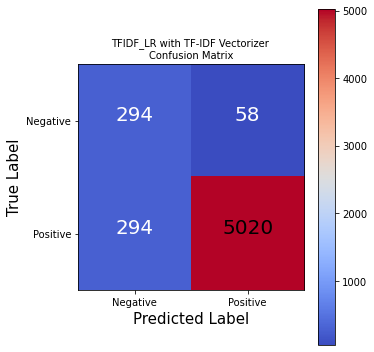

Saving the model metric...
Shape of newly formed performance metric:  (1, 3)
Shape of retrieved performance metric:  (1, 3)
Shape of concatenated dataframe:  (2, 3)
The TFIDF_LR model is saved into the disk...

Time Taken by the LR Classifier: 102.43 seconds


In [ ]:
# define the multinomial logistic regression model
lr = LogisticRegression()
params = {}

st_tm = time.time()
# Modeling process
model_name = "TV_LR"
vector = 'TF-IDF Vectorizer'
modeling_process(lr, model_name, params, vector, X_train_sm, y_train_sm)

print('\nTime Taken by the LR Classifier: {:.2f} seconds'.format(time.time() - st_tm))

*Random Forest Algorithm*

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 10.5 µs
Fitting 4 folds for each of 1 candidates, totalling 4 fits
The best score 0.8671498990324544
The parameters of the best classifier RandomForestClassifier(max_depth=20, max_features=15, min_samples_leaf=10,
                       n_estimators=500, n_jobs=-1, random_state=42)
Accuracy of the Classifier on Train data: 0.8708895893117561
Accuracy of the Classifier on Unseen data: 0.9336392516766678
f1 score: 0.9381546807327683


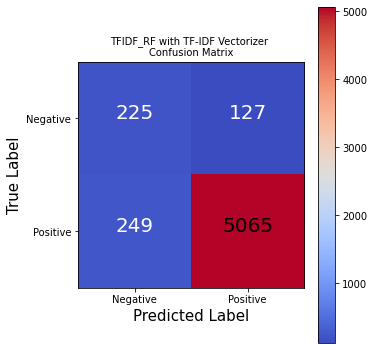

Saving the model metric...
Shape of newly formed performance metric:  (1, 3)
Shape of retrieved performance metric:  (2, 3)
Shape of concatenated dataframe:  (3, 3)
The TFIDF_RF model is saved into the disk...

Time Taken by the RF Classifier: 99.72 seconds


In [ ]:
# Training the classifier and predict on Test (unseen) data
params = {
    'max_depth': [20],
    'min_samples_leaf': [10],
    'n_estimators': [500], 
    'max_features': [15]
}
# Initiate a RF classifier
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

st_tm = time.time()
# Modeling process
model_name = "TV_RF"
vector = 'TF-IDF Vectorizer'
modeling_process(rf, model_name, params, vector, X_train_sm, y_train_sm)

print('\nTime Taken by the RF Classifier: {:.2f} seconds'.format(time.time() - st_tm))

*XGBoost Classifier*

In [ ]:
parameters = {'learning_rate': [0.3],
              'max_depth': [20, 50],
              'min_child_weight': [20, 25],
              'n_estimators': [500]}

xgb = XGBClassifier(random_state=42, n_jobs=-1)

st_tm = time.time()
# Modeling process
model_name = "TFIDF_XGB"
vector = 'TF-IDF Vectorizer'
modeling_process(xgb, model_name, params, vector, X_train_sm, y_train_sm)

print('\nTime Taken by the XGB Classifier: {:.2f} seconds'.format(time.time() - st_tm))

Let's review the performance of the models created so-far...

In [ ]:
 filepath = folderpath + 'model_metric.csv'
 dfModelPerf = pd.read_csv(filepath, index_col = 0)
 dfModelPerf

,Training_Accuracy_Score,Testing_Accuracy_Score,F1_Score
TV_NB,0.916780,0.816449,0.858736
TFIDF_LR,0.971562,0.937875,0.944968
TFIDF_RF,0.870890,0.933639,0.938155


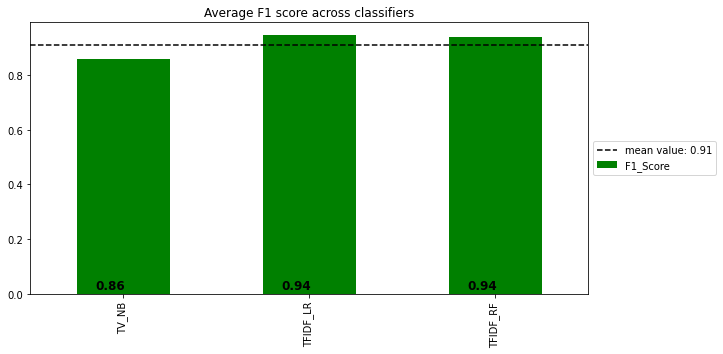

In [ ]:
# Show F1 score of all classifiers
col = "F1_Score"
title = "Average F1 score across classifiers"
color = "green"
show_modelmetric(col, dfModelPerf, title, color)

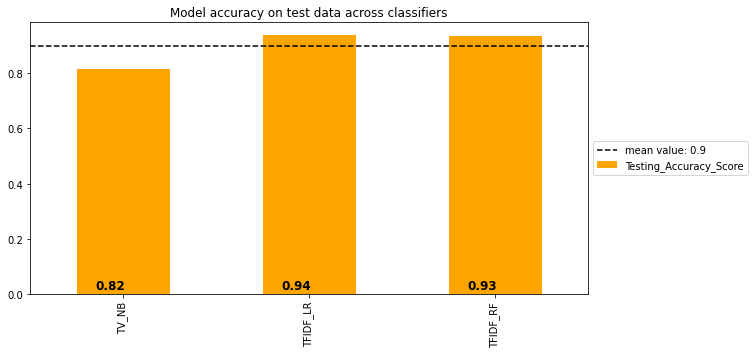

In [ ]:
# Show model accuracy on unseen data of all classifiers
col = "Testing_Accuracy_Score"
title = "Model accuracy on test data across classifiers"
color = "orange"
show_modelmetric(col, dfModelPerf, title, color)

#### Hashing Vectorizer

Hash Vectorizer is designed to be as memory efficient as possible. Instead of storing the tokens as strings, the vectorizer applies the hashing trick to encode them as numerical indexes.

In [ ]:
# to avoid NaN is the text column
df_train['r_text_lemma'] = df_train['r_text_lemma'].fillna(' ')
df_test['r_text_lemma'] = df_test['r_text_lemma'].fillna(' ')

In [ ]:
# Create the word vector with Hash Vectorizer
hash_vect = HashingVectorizer(stop_words='english', n_features=4000, ngram_range=(1,3))
hash_vect_train = hash_vect.fit_transform(df_train['r_text_lemma'])
hash_vect_test = hash_vect.transform(df_test['r_text_lemma'])

# create the Document Term Matrix
X_train = hash_vect_train.toarray()
X_test = hash_vect_test.toarray()

print(X_train.shape)
print(X_test.shape)

#Saving the TF-IDF vectorizer
filename = "hash_vect"
foldername = "vectorizers"
message = "Hashing vectorizer"
save_object(hash_vect, filename, foldername, message)

(22664, 4000)
(5666, 4000)
The Hashing vectorizer is saved into the disk...


In [ ]:
# setting up Y or dependent variable
y_train = df_train['sentiment_class_num']
y_test = df_test['sentiment_class_num']

print(y_train.shape)
print(y_test.shape)

(22664,)
(5666,)


In [ ]:
# Training the NB classifier and predict on Test (unseen) data
trialmodel_nb(X_train, y_train)

Accuracy of the Classifier on Train data: 0.8896929050476526
Accuracy of the Classifier on Unseen data 0.8535121779032827
Confusion Matrix
[[ 219  133]
 [ 697 4617]]
              precision    recall  f1-score   support

           0       0.24      0.62      0.35       352
           1       0.97      0.87      0.92      5314

    accuracy                           0.85      5666
   macro avg       0.61      0.75      0.63      5666
weighted avg       0.93      0.85      0.88      5666

f1 score: 0.8819860132632791


(GaussianNB(), [0.8896929050476526, 0.8535121779032827, 0.8819860132632791])

The trial Naive Bayes didn't perform badly as compare to TF-IDF Naive Bayes model however imbalance of data needs to be addressed

*Now SMOTE will be applied. SMOTE is an oversampling technique where the synthetic samples are generated for the minority class*

In [ ]:
counter = Counter(y_train)
print('Before applying SMOTE',counter)
sm = SMOTE()

# transform the dataset
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)

counter = Counter(y_train_sm)
print('After applying SMOTE',counter)

Before applying SMOTE Counter({1: 21257, 0: 1407})
After applying SMOTE Counter({1: 21257, 0: 21257})


In [ ]:
# Training the NB classifier and predict on Test (unseen) data
model, model_metric = trialmodel_nb(X_train_sm, y_train_sm)

model_name = "HV_NB"
# save the model
print("Saving the model metric...")
save_metric(model_name, model_metric)

#Saving the NB model
filename = model_name
foldername = "models"
message = "Naive-Bayes model"
save_object(model, filename, foldername, message)

Accuracy of the Classifier on Train data: 0.9085242508350191
Accuracy of the Classifier on Unseen data 0.9066360748323332
Confusion Matrix
[[ 126  226]
 [ 303 5011]]
              precision    recall  f1-score   support

           0       0.29      0.36      0.32       352
           1       0.96      0.94      0.95      5314

    accuracy                           0.91      5666
   macro avg       0.63      0.65      0.64      5666
weighted avg       0.92      0.91      0.91      5666

f1 score: 0.9108978421851488
Saving the model metric...
Shape of newly formed performance metric:  (1, 3)
Shape of retrieved performance metric:  (3, 3)
Shape of concatenated dataframe:  (4, 3)
The Naive-Bayes model is saved into the disk...


Improved performance - accuracy on test data has improved more than 4%. Overfitting issue has been addressed.

Now applying Random Over Sampling to address data imbalance issue

In [ ]:
counter = Counter(y_train)
print('Before applying Random Over Sampling',counter)
ros = over_sampling.RandomOverSampler(random_state=0)

# Oversampling the dataset.
X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)

counter = Counter(y_train_ros)
print('After applying Random Over Sampling',counter)

Before applying Random Over Sampling Counter({1: 21257, 0: 1407})
After applying Random Over Sampling Counter({1: 21257, 0: 21257})


In [ ]:
# Training the NB classifier and predict on Test (unseen) data
model, model_metric = trialmodel_nb(X_train_ros, y_train_ros)

model_name = "HV_NB_ROS"
# save the model
print("Saving the model metric...")
save_metric(model_name, model_metric)

#Saving the NB model
filename = model_name
foldername = "models"
message = "Naive-Bayes model"
save_object(model, filename, foldername, message)

Accuracy of the Classifier on Train data: 0.891800348120619
Accuracy of the Classifier on Unseen data 0.8517472643840451
Confusion Matrix
[[ 215  137]
 [ 703 4611]]
              precision    recall  f1-score   support

           0       0.23      0.61      0.34       352
           1       0.97      0.87      0.92      5314

    accuracy                           0.85      5666
   macro avg       0.60      0.74      0.63      5666
weighted avg       0.93      0.85      0.88      5666

f1 score: 0.8806134099183106
Saving the model metric...
Shape of newly formed performance metric:  (1, 3)
Shape of retrieved performance metric:  (4, 3)
Shape of concatenated dataframe:  (5, 3)
The Naive-Bayes model is saved into the disk...


Random Over Sampling didn't improve the performance of the actual model. Overfitting issue still persists.

*Logistic Regression Algorithm*

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.39 µs
Fitting 4 folds for each of 1 candidates, totalling 4 fits
The best score 0.9603660821989732
The parameters of the best classifier LogisticRegression()
Accuracy of the Classifier on Train data: 0.9745260384814414
Accuracy of the Classifier on Unseen data: 0.9355806565478292
f1 score: 0.9418145471458903


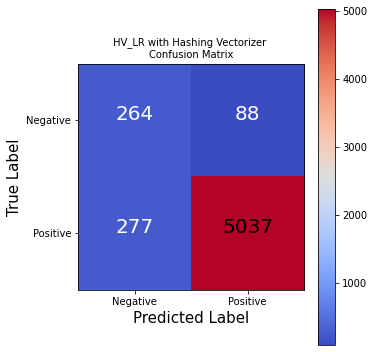

Saving the model metric...
Shape of newly formed performance metric:  (1, 3)
Shape of retrieved performance metric:  (5, 3)
Shape of concatenated dataframe:  (6, 3)
The HV_LR model is saved into the disk...

Time Taken by the LR Classifier: 87.38 seconds


In [ ]:
# define the multinomial logistic regression model
lr = LogisticRegression()
params = {}

st_tm = time.time()
# Modeling process
model_name = "HV_LR"
vector = 'Hashing Vectorizer'
modeling_process(lr, model_name, params, vector, X_train_sm, y_train_sm)

print('\nTime Taken by the LR Classifier: {:.2f} seconds'.format(time.time() - st_tm))

The model did very well. Model accuracy on unseen data is 94% and F1-score has improved significantly, nearly 95%.

*Random Forest Algorithm*

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 11.2 µs
Fitting 4 folds for each of 2 candidates, totalling 8 fits
The best score 0.8910949856757417
The parameters of the best classifier RandomForestClassifier(max_depth=20, max_features=15, min_samples_leaf=10,
                       n_estimators=500, n_jobs=-1, random_state=42)
Accuracy of the Classifier on Train data: 0.8956343792633015
Accuracy of the Classifier on Unseen data: 0.9465231203671021
f1 score: 0.945447118840554


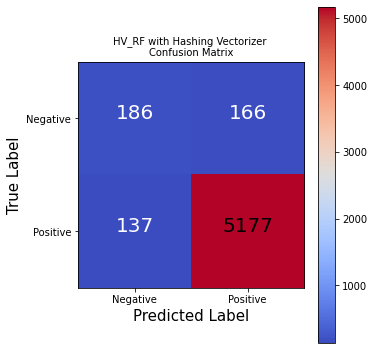

Saving the model metric...
Shape of newly formed performance metric:  (1, 3)
Shape of retrieved performance metric:  (6, 3)
Shape of concatenated dataframe:  (7, 3)
The HV_RF model is saved into the disk...

Time Taken by the RF Classifier: 504.01 seconds


In [ ]:
# Training the classifier and predict on Test (unseen) data
params = {
    'max_depth': [20],
    'min_samples_leaf': [10,20],
    'n_estimators': [500], 
    'max_features': [15]
}
# Initiate a RF classifier
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

st_tm = time.time()
# Modeling process
model_name = "HV_RF"
vector = 'Hashing Vectorizer'
modeling_process(rf, model_name, params, vector, X_train_sm, y_train_sm)

print('\nTime Taken by the RF Classifier: {:.2f} seconds'.format(time.time() - st_tm))

Accuracy on unseen data remains same to 94%. Interestingly, the accuracy on trained data has reduced to 89%. F1-score of the model is 94%. 

*XGBoost Classifier*

In [ ]:
parameters = {'learning_rate': [0.3],
              'max_depth': [50],
              'min_child_weight': [20],
              'n_estimators': [300]}

xgb = XGBClassifier(random_state=42, n_jobs=-1)

st_tm = time.time()
# Modeling process
model_name = "HV_XGB"
vector = 'Hashing Vectorizer'
modeling_process(xgb, model_name, params, vector, X_train_sm, y_train_sm)

print('\nTime Taken by the XGB Classifier: {:.2f} seconds'.format(time.time() - st_tm))

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.48 µs
Fitting 4 folds for each of 2 candidates, totalling 8 fits


exception calling callback for <Future at 0x7fc459048bd0 state=finished raised TerminatedWorkerError>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/_base.py", line 625, in _invoke_callbacks
    callback(self)
  File "/usr/local/lib/python3.7/dist-packages/joblib/parallel.py", line 359, in __call__
    self.parallel.dispatch_next()
  File "/usr/local/lib/python3.7/dist-packages/joblib/parallel.py", line 794, in dispatch_next
    if not self.dispatch_one_batch(self._original_iterator):
  File "/usr/local/lib/python3.7/dist-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/usr/local/lib/python3.7/dist-packages/joblib/parallel.py", line 779, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/usr/local/lib/python3.7/dist-packages/joblib/_parallel_backends.py", line 531, in apply_async
    future = self._workers.submit(SafeFunction(func))
  File "/usr/local/lib/

TerminatedWorkerError: ignored

**Reviewing the performance of all the models built and trained so-far...**

In [ ]:
# Model performance comparison
filepath = folderpath + 'model_metric.csv'
dfModelPerf = pd.read_csv(filepath, index_col = 0)
dfModelPerf

,Training_Accuracy_Score,Testing_Accuracy_Score,F1_Score
TV_NB,0.916780,0.816449,0.858736
TFIDF_LR,0.971562,0.937875,0.944968
TFIDF_RF,0.870890,0.933639,0.938155
HV_NB,0.908524,0.906636,0.910898
HV_NB_ROS,0.891800,0.851747,0.880613
HV_LR,0.974526,0.935581,0.941815
HV_RF,0.895634,0.946523,0.945447


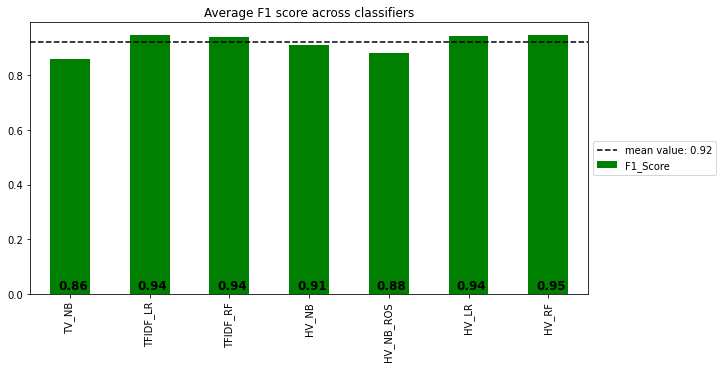

In [ ]:
# Show F1 score of all classifiers
col = "F1_Score"
title = "Average F1 score across classifiers"
color = "green"
show_modelmetric(col, dfModelPerf, title, color)

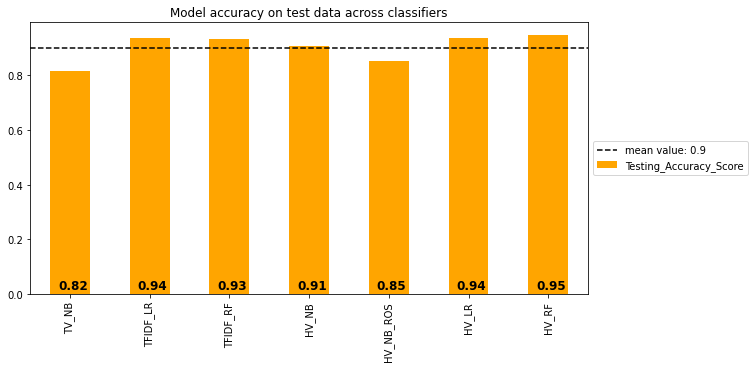

In [ ]:
# Show model accuracy on unseen data of all classifiers
col = "Testing_Accuracy_Score"
title = "Model accuracy on test data across classifiers"
color = "orange"
show_modelmetric(col, dfModelPerf, title, color)

**While executing the model building code of multiple classifiers in one sequence, we faced issue due to excessive usage of memory.**

Typical error statement is as below:
"*TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker.*"

Hence as a work-around executed the various classifier code separately and we did many interim data save in the disk to speed-up the execution. 

#### Conclusion on the best model of Sentiment Analysis

The Linear Regression model using TF-IDF or Hashing vectorizer has outperformed other algorithms. The F1-score of the model is quite consistent and model accuracy on test data is 94% and there is no overfitting issue. Although the accuracy of Random Forest on test data is 95% however on training data surprisingly it didn't perform as expected, hence disgarded.  

## Recommendation System

The original data is already cleaned, preprocessed, corrected & split into train and test datasets.

We don't want further split of data in different ratio between train and test. The same train data used to train sentiment classifier/s will be used to train the recommendation engine and finally will be tested upon the same test data. In this way, we can have consistency between two types of models.

In [ ]:
# Read the train data
filepath = folderpath + 'review_train.csv'
df_train = pd.read_csv(filepath)

print(df_train.shape)
df_train.head(3)

(22664, 12)


,id,brand,categories,name,rating,r_text,r_title,user_name,user_sentiment,revised_sentiment,r_text_lemma,sentiment_class_num
0,AVpfJP1C1cnluZ0-e3Xy,Clorox,"Household Chemicals,Household Cleaners,Bath & ...",Clorox Disinfecting Bathroom Cleaner,5,Can't live without these wipes! I use them for...,Perfect for Everyday Cleaning,kuponkook,Positive,Positive,live without wipe use absolutely everything,1
1,AVpfJP1C1cnluZ0-e3Xy,Clorox,"Household Chemicals,Household Cleaners,Bath & ...",Clorox Disinfecting Bathroom Cleaner,5,These are my favorite disinfecting wipes! They...,These are my favorite disinfecting wipes!,lizard22,Positive,Positive,favorite disinfect wipe work great love smell ...,1
2,AVpfJP1C1cnluZ0-e3Xy,Clorox,"Household Chemicals,Household Cleaners,Bath & ...",Clorox Disinfecting Bathroom Cleaner,5,I use it for the toilet specially and my kitch...,excellent,gatitata,Positive,Positive,use toilet specially kitchen love,1


In [ ]:
# Read the test data
filepath = folderpath + 'review_test.csv'
df_test = pd.read_csv(filepath)

print(df_test.shape)
df_test.head(3)

(5666, 12)


,id,brand,categories,name,rating,r_text,r_title,user_name,user_sentiment,revised_sentiment,r_text_lemma,sentiment_class_num
0,AVpf385g1cnluZ0-s0_t,Hormel,"Food,Packaged Foods,Canned Foods,Canned Meals,...","Hormel Chili, No Beans",5,My man grew up with this and he loves it for c...,Hotdogs,rggatorgal,Positive,Positive,man grow love chili use sauce hot dog either w...,1
1,AVpf0eb2LJeJML43EVSt,Sony Pictures,"Movies, Music & Books,Ways To Shop Entertainme...",The Resident Evil Collection 5 Discs (blu-Ray),5,I played the original game which is what got m...,Great movie collection at a good price,marvilleous,Positive,Positive,play original game get watch first movie watch...,1
2,AVpf385g1cnluZ0-s0_t,Hormel,"Food,Packaged Foods,Canned Foods,Canned Meals,...","Hormel Chili, No Beans",5,Great product always use when grilling hot dog...,Hormel,cmeche,Positive,Positive,great product always use grill hot dog etc,1


*Considering only relevant attributes applicable for recommendation engine*

In [ ]:
df_train = df_train[["id","brand","user_name","rating"]]
df_train.head(3)

,id,brand,user_name,rating
0,AVpfJP1C1cnluZ0-e3Xy,Clorox,kuponkook,5
1,AVpfJP1C1cnluZ0-e3Xy,Clorox,lizard22,5
2,AVpfJP1C1cnluZ0-e3Xy,Clorox,gatitata,5


In [ ]:
df_test = df_test[["id","brand","user_name","rating"]]
df_test.head(3)

,id,brand,user_name,rating
0,AVpf385g1cnluZ0-s0_t,Hormel,rggatorgal,5
1,AVpf0eb2LJeJML43EVSt,Sony Pictures,marvilleous,5
2,AVpf385g1cnluZ0-s0_t,Hormel,cmeche,5


In [ ]:
# checking duplicate records in train dataset
duplicate = df_train[df_train.duplicated()]
len(duplicate)

1179

In [ ]:
# Removing duplicate records from train dataset. keep = ‘last’: drop duplicates except for the last occurrence
df_train.drop_duplicates(keep = 'last', inplace = True)
duplicate = df_train[df_train.duplicated()]
print("Number of duplicate records:", len(duplicate))
print("Remaining records after removing duplicates:", len(df_train))

Number of duplicate records: 0
Remaining records after removing duplicates: 21485


In [ ]:
# checking whether duplicates still present or not
df_train[(df_train["user_name"] == "adam") & (df_train["id"] == "AVpfPaoqLJeJML435Xk9")]

,id,brand,user_name,rating
12355,AVpfPaoqLJeJML435Xk9,Warner Home Video,adam,4
22622,AVpfPaoqLJeJML435Xk9,Warner Home Video,adam,5


In [ ]:
# checking duplicate records in test dataset
duplicate = df_test[df_test.duplicated()]
len(duplicate)

79

In [ ]:
# Removing duplicate records from test dataset. keep = ‘last’: drop duplicates except for the last occurrence
df_test.drop_duplicates(keep = 'last', inplace = True)
duplicate = df_test[df_test.duplicated()]
print("Number of duplicate records:", len(duplicate))
print("Remaining records after removing duplicates:", len(df_test))

Number of duplicate records: 0
Remaining records after removing duplicates: 5587


### Used based Recommendation

There are duplicates which were not present in the train dataset while doing Sentiment analysis because user review texts might be differing across records of same product and user-name. However, during collaborative filtering technique, we don't consider user review text rather user rating is observed. Hence, mean value of different ratings for a product by the user will be determined and added to the relationship between product and user-name.    

In [ ]:
# Pivot the train dataset into matrix format in which columns are product ids and the rows are user-names. 
# Zero('0') rating to the product which has not been rated by the corresponding user 
df_train_pivot = df_train.pivot_table(
    index = 'user_name',
    columns = 'id',
    values = 'rating',
    aggfunc = np.nanmean
).fillna(0)

print("Length of Pivot table:", len(df_train_pivot))
df_train_pivot.head(5)

Length of Pivot table: 19613


id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1Ynb3bglJLPUi8IJxJ,AV1YneDPglJLPUi8IJyQ,AV1YpiJvvKc47QAVguxy,AV1YqAaMGV-KLJ3adiDj,AV1Ys0kTvKc47QAVgx1C,AV1YtGjdglJLPUi8IOfJ,AV1ZSp2uglJLPUi8IQFy,AV1ZT7GLglJLPUi8IQLI,AV1ZVIgy-jtxr-f31W9N,AV1d76w7vKc47QAVhCqn,AV1h6Gu0glJLPUi8IjA_,AV1h6gSl-jtxr-f31p40,AV1l8zRZvKc47QAVhnAv,AV2AvGnjGV-KLJ3alTQH,AV2Avn5dGV-KLJ3alTjq,AV2BOOWS-jtxr-f39GPS,AVpe-M4-ilAPnD_xSF1K,AVpe-PJnLJeJML43ziaj,AVpe-ltS1cnluZ0-bL8w,AVpe31o71cnluZ0-YrSD,AVpe38Uy1cnluZ0-YuJR,AVpe3_ikilAPnD_xPykq,AVpe4-GPLJeJML43xmuY,AVpe41TqilAPnD_xQH3d,AVpe4Bq81cnluZ0-YwTN,AVpe4hE0ilAPnD_xQABx,AVpe4hlXLJeJML43xbrB,AVpe4pnBilAPnD_xQDeb,AVpe59io1cnluZ0-ZgDU,AVpe5AMsLJeJML43xnku,...,AVpfiUrfLJeJML43-9nY,AVpfifml1cnluZ0-mjSb,AVpfjHuw1cnluZ0-mvrX,AVpfjauJLJeJML43_TKe,AVpfk4y7ilAPnD_xeTgd,AVpfkIiYilAPnD_xeEjr,AVpfkQkcLJeJML43_kEC,AVpfkak01cnluZ0-nJj6,AVpfksililAPnD_xePx_,AVpfl6baLJeJML43AEQq,AVpfl6sF1cnluZ0-nmwC,AVpfldDlLJeJML43_7s_,AVpfliCoilAPnD_xegIr,AVpfluP1ilAPnD_xejxO,AVpfm8yiLJeJML43AYyu,AVpfmVnVLJeJML43AMqC,AVpfmjXGLJeJML43AQ5_,AVpfml2VilAPnD_xe0m6,AVpfnRuSilAPnD_xfB8l,AVpfnS4eLJeJML43AfZe,AVpfnUcwLJeJML43Af2U,AVpfnjBILJeJML43AkO3,AVpfoSS51cnluZ0-oVH9,AVpfov9TLJeJML43A7B0,AVpfozgyilAPnD_xfe0r,AVpfpM2yilAPnD_xfmDG,AVpfqW4WilAPnD_xf7a_,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfs0tUilAPnD_xgqN2,AVpfsQoeilAPnD_xgfx5,AVpfshNsLJeJML43CB8q,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpftymALJeJML43CZ6y,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
user_name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00dog3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02dakota,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02deuce,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0325home,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
06stidriver,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Creating dummy train & dummy test dataset
These dataset will be used for prediction 
- Dummy train will be used later for prediction of the products which has not been rated by the user. To ignore the products rated by the user, we will mark it as 0 during prediction. The products not rated by user is marked as 1 for prediction in dummy train dataset. 

- Dummy test will be used for evaluation. To evaluate, we will only make prediction on the products rated by the user. So, this is marked as 1. This is just opposite of dummy_train.

In [ ]:
# Copy the train dataset into dummy_train
dummy_train = df_train.copy()
dummy_train.head()

,id,brand,user_name,rating
0,AVpfJP1C1cnluZ0-e3Xy,Clorox,kuponkook,5
1,AVpfJP1C1cnluZ0-e3Xy,Clorox,lizard22,5
3,AVpfPnrU1cnluZ0-g9rL,Lionsgate,rainmt,5
6,AVpf0thK1cnluZ0-r8vR,Warner Bros.,ronaele,4
7,AVpfJP1C1cnluZ0-e3Xy,Clorox,nic03,5


In [ ]:
# The products not rated by user is marked as 1 for prediction. 
dummy_train['rating'] = dummy_train['rating'].apply(lambda x: 0 if x>=1 else 1)
dummy_train.head()

,id,brand,user_name,rating
0,AVpfJP1C1cnluZ0-e3Xy,Clorox,kuponkook,0
1,AVpfJP1C1cnluZ0-e3Xy,Clorox,lizard22,0
3,AVpfPnrU1cnluZ0-g9rL,Lionsgate,rainmt,0
6,AVpf0thK1cnluZ0-r8vR,Warner Bros.,ronaele,0
7,AVpfJP1C1cnluZ0-e3Xy,Clorox,nic03,0


In [ ]:
# checking whether duplicates still present or not
dummy_train[(dummy_train["user_name"] == "adam") & (dummy_train["id"] == "AVpfPaoqLJeJML435Xk9")]

,id,brand,user_name,rating
12355,AVpfPaoqLJeJML435Xk9,Warner Home Video,adam,0
22622,AVpfPaoqLJeJML435Xk9,Warner Home Video,adam,0


In [ ]:
# Convert the dummy train dataset into matrix format. 
# In case of duplicate records where ratings are 1 mean value of those 1s is nothing but 1 
# In case of duplicate records where ratings are Zero(0) mean value of those 1s is nothing but 0 
dummy_train = dummy_train.pivot_table(
    index = 'user_name',
    columns = 'id',
    values = 'rating',
    aggfunc = np.nanmean
).fillna(1)

dummy_train.head()

id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1Ynb3bglJLPUi8IJxJ,AV1YneDPglJLPUi8IJyQ,AV1YpiJvvKc47QAVguxy,AV1YqAaMGV-KLJ3adiDj,AV1Ys0kTvKc47QAVgx1C,AV1YtGjdglJLPUi8IOfJ,AV1ZSp2uglJLPUi8IQFy,AV1ZT7GLglJLPUi8IQLI,AV1ZVIgy-jtxr-f31W9N,AV1d76w7vKc47QAVhCqn,AV1h6Gu0glJLPUi8IjA_,AV1h6gSl-jtxr-f31p40,AV1l8zRZvKc47QAVhnAv,AV2AvGnjGV-KLJ3alTQH,AV2Avn5dGV-KLJ3alTjq,AV2BOOWS-jtxr-f39GPS,AVpe-M4-ilAPnD_xSF1K,AVpe-PJnLJeJML43ziaj,AVpe-ltS1cnluZ0-bL8w,AVpe31o71cnluZ0-YrSD,AVpe38Uy1cnluZ0-YuJR,AVpe3_ikilAPnD_xPykq,AVpe4-GPLJeJML43xmuY,AVpe41TqilAPnD_xQH3d,AVpe4Bq81cnluZ0-YwTN,AVpe4hE0ilAPnD_xQABx,AVpe4hlXLJeJML43xbrB,AVpe4pnBilAPnD_xQDeb,AVpe59io1cnluZ0-ZgDU,AVpe5AMsLJeJML43xnku,...,AVpfiUrfLJeJML43-9nY,AVpfifml1cnluZ0-mjSb,AVpfjHuw1cnluZ0-mvrX,AVpfjauJLJeJML43_TKe,AVpfk4y7ilAPnD_xeTgd,AVpfkIiYilAPnD_xeEjr,AVpfkQkcLJeJML43_kEC,AVpfkak01cnluZ0-nJj6,AVpfksililAPnD_xePx_,AVpfl6baLJeJML43AEQq,AVpfl6sF1cnluZ0-nmwC,AVpfldDlLJeJML43_7s_,AVpfliCoilAPnD_xegIr,AVpfluP1ilAPnD_xejxO,AVpfm8yiLJeJML43AYyu,AVpfmVnVLJeJML43AMqC,AVpfmjXGLJeJML43AQ5_,AVpfml2VilAPnD_xe0m6,AVpfnRuSilAPnD_xfB8l,AVpfnS4eLJeJML43AfZe,AVpfnUcwLJeJML43Af2U,AVpfnjBILJeJML43AkO3,AVpfoSS51cnluZ0-oVH9,AVpfov9TLJeJML43A7B0,AVpfozgyilAPnD_xfe0r,AVpfpM2yilAPnD_xfmDG,AVpfqW4WilAPnD_xf7a_,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfs0tUilAPnD_xgqN2,AVpfsQoeilAPnD_xgfx5,AVpfshNsLJeJML43CB8q,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpftymALJeJML43CZ6y,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
user_name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00dog3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
02dakota,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
02deuce,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
0325home,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
06stidriver,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


User based similarity matrix - using Cosine similarity

In [ ]:
# Creating the User Similarity Matrix using pairwise_distance function.
user_correlation = 1 - pairwise_distances(df_train_pivot, metric='cosine')
user_correlation[np.isnan(user_correlation)] = 0
print(user_correlation.shape)
print(user_correlation)

(19613, 19613)
[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 1. ... 0. 0. 0.]
 [0. 1. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 1.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 1. 0. 1.]]


#### Prediction: User-User

Doing the prediction for the users which are positively related with other users, and not the users which are negatively related as we are interested in the users which are more similar to the current users. So, ignoring the correlation for values less than 0.

In [ ]:
user_correlation[user_correlation < 0] = 0
user_correlation

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 1.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 1., 0., 1.]])

Rating predicted by the user (for products rated as well as not rated) is the weighted sum of correlation with the product rating (as present in the rating dataset). 

In [ ]:
#matrix multiplcation (dot product) between corelated matrix and user-item matrix
user_predicted_ratings = np.dot(user_correlation, df_train_pivot.fillna(0))
print(user_predicted_ratings.shape)
user_predicted_ratings

(19613, 250)


array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 3.1172134 , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 3.1172134 , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.40689423, ..., 0.        , 0.        ,
        2.88675135],
       [0.        , 0.        , 0.        , ..., 0.        , 2.27038305,
        0.70014004],
       [0.        , 0.        , 0.40689423, ..., 0.        , 0.        ,
        2.88675135]])

Since we are interested only in the products not rated by the user, we will ignore the products rated by the user by making it zero. 

In [ ]:
user_final_rating = np.multiply(user_predicted_ratings,dummy_train)
user_final_rating.head()

id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1Ynb3bglJLPUi8IJxJ,AV1YneDPglJLPUi8IJyQ,AV1YpiJvvKc47QAVguxy,AV1YqAaMGV-KLJ3adiDj,AV1Ys0kTvKc47QAVgx1C,AV1YtGjdglJLPUi8IOfJ,AV1ZSp2uglJLPUi8IQFy,AV1ZT7GLglJLPUi8IQLI,AV1ZVIgy-jtxr-f31W9N,AV1d76w7vKc47QAVhCqn,AV1h6Gu0glJLPUi8IjA_,AV1h6gSl-jtxr-f31p40,AV1l8zRZvKc47QAVhnAv,AV2AvGnjGV-KLJ3alTQH,AV2Avn5dGV-KLJ3alTjq,AV2BOOWS-jtxr-f39GPS,AVpe-M4-ilAPnD_xSF1K,AVpe-PJnLJeJML43ziaj,AVpe-ltS1cnluZ0-bL8w,AVpe31o71cnluZ0-YrSD,AVpe38Uy1cnluZ0-YuJR,AVpe3_ikilAPnD_xPykq,AVpe4-GPLJeJML43xmuY,AVpe41TqilAPnD_xQH3d,AVpe4Bq81cnluZ0-YwTN,AVpe4hE0ilAPnD_xQABx,AVpe4hlXLJeJML43xbrB,AVpe4pnBilAPnD_xQDeb,AVpe59io1cnluZ0-ZgDU,AVpe5AMsLJeJML43xnku,...,AVpfiUrfLJeJML43-9nY,AVpfifml1cnluZ0-mjSb,AVpfjHuw1cnluZ0-mvrX,AVpfjauJLJeJML43_TKe,AVpfk4y7ilAPnD_xeTgd,AVpfkIiYilAPnD_xeEjr,AVpfkQkcLJeJML43_kEC,AVpfkak01cnluZ0-nJj6,AVpfksililAPnD_xePx_,AVpfl6baLJeJML43AEQq,AVpfl6sF1cnluZ0-nmwC,AVpfldDlLJeJML43_7s_,AVpfliCoilAPnD_xegIr,AVpfluP1ilAPnD_xejxO,AVpfm8yiLJeJML43AYyu,AVpfmVnVLJeJML43AMqC,AVpfmjXGLJeJML43AQ5_,AVpfml2VilAPnD_xe0m6,AVpfnRuSilAPnD_xfB8l,AVpfnS4eLJeJML43AfZe,AVpfnUcwLJeJML43Af2U,AVpfnjBILJeJML43AkO3,AVpfoSS51cnluZ0-oVH9,AVpfov9TLJeJML43A7B0,AVpfozgyilAPnD_xfe0r,AVpfpM2yilAPnD_xfmDG,AVpfqW4WilAPnD_xf7a_,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfs0tUilAPnD_xgqN2,AVpfsQoeilAPnD_xgfx5,AVpfshNsLJeJML43CB8q,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpftymALJeJML43CZ6y,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
user_name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00dog3,0.0,0.0,0.000000,1.725164,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,7.038519,0.0,0.0,0.00000,0.0,3.642576,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.345033,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.000000,0.000000,0.00000,0.000000,0.0,0.000000,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000
02dakota,0.0,0.0,3.117213,20.442575,0.0,0.0,0.0,0.000000,2.691910,1.766904,0.0,2.051823,0.0,1.849001,1.402148,1.402148,5.753569,3.123475,0.0,2.620712,3.123475,0.0,14.023403,0.0,0.0,0.0,0.0,0.0,0.0,20.827839,0.0,0.0,0.0,116.601643,0.0,0.0,1.73762,0.0,67.439583,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,9.354339,0.0,0.0,0.0,3.740689,0.0,0.0,0.96225,3.543719,9.468669,4.04225,4.773503,0.0,4.427588,3.83419,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,3.761278,0.0,0.0,0.000000
02deuce,0.0,0.0,3.117213,20.442575,0.0,0.0,0.0,0.000000,2.691910,1.766904,0.0,2.051823,0.0,1.849001,1.402148,1.402148,5.753569,3.123475,0.0,2.620712,3.123475,0.0,14.023403,0.0,0.0,0.0,0.0,0.0,0.0,20.827839,0.0,0.0,0.0,116.601643,0.0,0.0,1.73762,0.0,67.439583,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,9.354339,0.0,0.0,0.0,3.740689,0.0,0.0,0.96225,3.543719,9.468669,4.04225,4.773503,0.0,4.427588,3.83419,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,3.761278,0.0,0.0,0.000000
0325home,0.0,0.0,0.406894,8.797622,0.0,0.0,0.0,6.659009,3.535534,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,15.115766,0.0,0.0,0.0,0.0,0.0,0.0,2.208631,0.0,0.0,0.0,31.551755,0.0,0.0,0.00000,0.0,26.496190,0.0,...,0.0,0.0,3.535534,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.731784,6.151593,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,1.808937,2.886751,0.00000,2.620712,0.0,0.000000,0.00000,0.0,3.535534,0.0,0.0,0.0,0.0,4.332638,3.535534,0.0,0.0,2.886751
06stidriver,0.0,0.0,0.406894,8.797622,0.0,0.0,0.0,6.659009,3.535534,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,15.115766,0.0,0.0,0.0,0.0,0.0,0.0,2.208631,0.0,0.0,0.0,31.551755,0.0,

***Finding the Top 20 recommendation for a user***

In [ ]:
# suggested products for randomly picked user_name
uname = "02deuce"
suggested_product_1 = user_final_rating.loc[uname].sort_values(ascending=False)[0:20]
suggested_product_1 = suggested_product_1.reset_index()
suggested_product_1.columns = ['id','score']
suggested_product_1

,id,score
0,AVpfRTh1ilAPnD_xYic2,162.295442
1,AVpe41TqilAPnD_xQH3d,116.601643
2,AVpf0eb2LJeJML43EVSt,97.234982
3,AVpf2tw1ilAPnD_xjflC,78.416066
4,AVpf3VOfilAPnD_xjpun,76.011906
5,AVpe59io1cnluZ0-ZgDU,67.439583
6,AVpfJP1C1cnluZ0-e3Xy,31.854697
7,AVpfPnrU1cnluZ0-g9rL,30.409310
8,AVpf0thK1cnluZ0-r8vR,29.080002
9,AVpfD9xTLJeJML431ig2,27.718881


Checking whether the rated product is rated again or not

In [ ]:
print(df_train[df_train["user_name"] == uname])
print(user_final_rating.loc[uname, "AVpfPaoqLJeJML435Xk9"])

                        id              brand user_name  rating
2696  AVpfPaoqLJeJML435Xk9  Warner Home Video   02deuce       4
0.0


The model ensures that the product/s rated by user is/are not recommended 

In [ ]:
# find unique products and corresponding brand
uniq_prod = df_train.drop_duplicates(['id','brand'])[['id','brand']]
print(len(uniq_prod))
uniq_prod.head()

250


,id,brand
0,AVpfJP1C1cnluZ0-e3Xy,Clorox
3,AVpfPnrU1cnluZ0-g9rL,Lionsgate
6,AVpf0thK1cnluZ0-r8vR,Warner Bros.
8,AVpfM_ytilAPnD_xXIJb,Tostitos
9,AVpe8gsILJeJML43y6Ed,Pendaflex


In [ ]:
suggested_product_1 = pd.merge(suggested_product_1,uniq_prod,left_on='id',right_on='id', how = 'left')
suggested_product_1

,id,score,brand
0,AVpfRTh1ilAPnD_xYic2,162.295442,Disney
1,AVpe41TqilAPnD_xQH3d,116.601643,FOX
2,AVpf0eb2LJeJML43EVSt,97.234982,Sony Pictures
3,AVpf2tw1ilAPnD_xjflC,78.416066,Summit Entertainment
4,AVpf3VOfilAPnD_xjpun,76.011906,Clorox
5,AVpe59io1cnluZ0-ZgDU,67.439583,Universal Home Video
6,AVpfJP1C1cnluZ0-e3Xy,31.854697,Clorox
7,AVpfPnrU1cnluZ0-g9rL,30.409310,Lionsgate
8,AVpf0thK1cnluZ0-r8vR,29.080002,Warner Bros.
9,AVpfD9xTLJeJML431ig2,27.718881,FOX


#### Evaluation: User-User

In [ ]:
# Find out the common users of test and train dataset.
common = df_test[df_test["user_name"].isin(df_train["user_name"])]
print(common.shape)
common.head()

(1274, 4)


,id,brand,user_name,rating
8,AVpf5ujMilAPnD_xkQVi,D-Con,anne,1
12,AV1YGDqsGV-KLJ3adc-O,Windex,rhz,5
15,AVpfW8y_LJeJML437ySW,L'oreal Paris,kw123,4
25,AVpfJP1C1cnluZ0-e3Xy,Clorox,kristalb,5
26,AVpfRTh1ilAPnD_xYic2,Disney,tony,5


In [ ]:
# Pivot the test dataset into matrix format in which columns are product ids and the rows are user-names. 
# Zero('0') rating to the product which has not been rated by the corresponding user 
df_test_pivot = df_test.pivot_table(
    index = 'user_name',
    columns = 'id',
    values = 'rating',
    aggfunc = np.nanmean
).fillna(0)

print("Length of Pivot table:", len(df_test_pivot))
df_test_pivot.head(5)

Length of Pivot table: 5412


id,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1YnUMYglJLPUi8IJpK,AV1Ynb3bglJLPUi8IJxJ,AV1YneDPglJLPUi8IJyQ,AV1Yo6FPglJLPUi8IK3u,AV1YqAaMGV-KLJ3adiDj,AV1Ys0kTvKc47QAVgx1C,AV1YtGjdglJLPUi8IOfJ,AV1ZSp2uglJLPUi8IQFy,AV1ZT7GLglJLPUi8IQLI,AV1ZVIgy-jtxr-f31W9N,AV1d76w7vKc47QAVhCqn,AV1h6Gu0glJLPUi8IjA_,AV1l8zRZvKc47QAVhnAv,AVpe-M4-ilAPnD_xSF1K,AVpe-PJnLJeJML43ziaj,AVpe-YAL1cnluZ0-bHGh,AVpe-ltS1cnluZ0-bL8w,AVpe31o71cnluZ0-YrSD,AVpe38Uy1cnluZ0-YuJR,AVpe3_ikilAPnD_xPykq,AVpe41TqilAPnD_xQH3d,AVpe4hlXLJeJML43xbrB,AVpe4pnBilAPnD_xQDeb,AVpe59io1cnluZ0-ZgDU,AVpe5JOgilAPnD_xQPfE,AVpe5Mv4ilAPnD_xQQyy,AVpe5c23LJeJML43xybi,AVpe5s3RLJeJML43x4eA,AVpe5tC61cnluZ0-ZZ86,AVpe5ttZLJeJML43x4yO,AVpe6CHv1cnluZ0-ZhwN,AVpe6FfKilAPnD_xQmHi,AVpe6FpaLJeJML43yBuP,...,AVpfbpzd1cnluZ0-kqJV,AVpfbraG1cnluZ0-kqnn,AVpfcu821cnluZ0-k8ep,AVpfdYUZilAPnD_xcHuK,AVpfddjcLJeJML439loo,AVpfe3On1cnluZ0-lgn5,AVpfewoLilAPnD_xcfgU,AVpfgvkJLJeJML43-g1y,AVpfhxaELJeJML43-zsM,AVpfi79RLJeJML43_Jo0,AVpfiUrfLJeJML43-9nY,AVpfjHuw1cnluZ0-mvrX,AVpfjauJLJeJML43_TKe,AVpfk4y7ilAPnD_xeTgd,AVpfkIiYilAPnD_xeEjr,AVpfkQkcLJeJML43_kEC,AVpfkak01cnluZ0-nJj6,AVpfl6baLJeJML43AEQq,AVpflENxilAPnD_xeXFF,AVpfldDlLJeJML43_7s_,AVpfluP1ilAPnD_xejxO,AVpfm8yiLJeJML43AYyu,AVpfmjXGLJeJML43AQ5_,AVpfnRuSilAPnD_xfB8l,AVpfnS4eLJeJML43AfZe,AVpfnjBILJeJML43AkO3,AVpfoSS51cnluZ0-oVH9,AVpfov9TLJeJML43A7B0,AVpfpM2yilAPnD_xfmDG,AVpfpoUCLJeJML43BLXv,AVpfqW4WilAPnD_xf7a_,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfs0tUilAPnD_xgqN2,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpfvieo1cnluZ0-qdnu
user_name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00sab00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
08dallas,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11111111aaaaaaaaaaaaaaaaa,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1234561,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
123cat123,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
df_train[(df_train["user_name"] == "anne")]

,id,brand,user_name,rating
5942,AVpe5JOgilAPnD_xQPfE,Sony Music,anne,5
18811,AVpe8gsILJeJML43y6Ed,Pendaflex,anne,5
21283,AVpfpM2yilAPnD_xfmDG,Ragu,anne,5


In [ ]:
df_test[(df_test["user_name"] == "anne")]

,id,brand,user_name,rating
8,AVpf5ujMilAPnD_xkQVi,D-Con,anne,1
3455,AVpfPaoqLJeJML435Xk9,Warner Home Video,anne,5
4600,AVpf3VOfilAPnD_xjpun,Clorox,anne,5


In [ ]:
# Pivot the test dataset into matrix format in which columns are product ids and the rows are user-names. 
# Zero('0') rating to the product which has not been rated by the corresponding user 
common_pivot = common.pivot_table(
    index = 'user_name',
    columns = 'id',
    values = 'rating'
)

print("Length of Pivot table:", len(common_pivot))
common_pivot.head(5)

Length of Pivot table: 1143


id,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1Ymf_rglJLPUi8II2v,AV1YnUMYglJLPUi8IJpK,AV1YqAaMGV-KLJ3adiDj,AV1Ys0kTvKc47QAVgx1C,AV1YtGjdglJLPUi8IOfJ,AV1ZT7GLglJLPUi8IQLI,AV1ZVIgy-jtxr-f31W9N,AV1h6Gu0glJLPUi8IjA_,AV1l8zRZvKc47QAVhnAv,AVpe-PJnLJeJML43ziaj,AVpe-ltS1cnluZ0-bL8w,AVpe31o71cnluZ0-YrSD,AVpe41TqilAPnD_xQH3d,AVpe4pnBilAPnD_xQDeb,AVpe59io1cnluZ0-ZgDU,AVpe5c23LJeJML43xybi,AVpe5s3RLJeJML43x4eA,AVpe6FpaLJeJML43yBuP,AVpe6n2_LJeJML43yOgE,AVpe71Vk1cnluZ0-aL_Z,AVpe78stLJeJML43ytOY,AVpe7sl91cnluZ0-aI1Y,AVpe7zdzLJeJML43yp3d,AVpe8gsILJeJML43y6Ed,AVpe8xjUilAPnD_xRkxC,AVpe9W4D1cnluZ0-avf0,AVpe_N91LJeJML43z4jD,AVpf--o9LJeJML43G_Fq,AVpf0O60ilAPnD_xizE6,AVpf0YhQLJeJML43ETff,AVpf0eb2LJeJML43EVSt,AVpf0pfrilAPnD_xi6s_,AVpf0thK1cnluZ0-r8vR,AVpf1pwXLJeJML43EqpT,AVpf2tw1ilAPnD_xjflC,AVpf385g1cnluZ0-s0_t,AVpf3VOfilAPnD_xjpun,AVpf3okQLJeJML43FMif,...,AVpfJcHuLJeJML433ZrY,AVpfLnfPLJeJML434HpK,AVpfM_ytilAPnD_xXIJb,AVpfMpZ51cnluZ0-f_L9,AVpfN6Z71cnluZ0-gZmO,AVpfNc9cLJeJML434tza,AVpfOIrkilAPnD_xXgDG,AVpfOfIqLJeJML435D06,AVpfOmKwLJeJML435GM7,AVpfPPkEilAPnD_xX3cP,AVpfPaoqLJeJML435Xk9,AVpfPnrU1cnluZ0-g9rL,AVpfQtEm1cnluZ0-hUpe,AVpfR5m0LJeJML436K3W,AVpfRTh1ilAPnD_xYic2,AVpfRYbSilAPnD_xYkD4,AVpfRoqcLJeJML436FqG,AVpfSvmGilAPnD_xY_gE,AVpfUN2nilAPnD_xZeY3,AVpfVPh3ilAPnD_xZzW9,AVpfW8y_LJeJML437ySW,AVpfazX31cnluZ0-kbdl,AVpfbkyr1cnluZ0-kozI,AVpfbraG1cnluZ0-kqnn,AVpfcu821cnluZ0-k8ep,AVpfgvkJLJeJML43-g1y,AVpfi79RLJeJML43_Jo0,AVpfiUrfLJeJML43-9nY,AVpfk4y7ilAPnD_xeTgd,AVpfkQkcLJeJML43_kEC,AVpflENxilAPnD_xeXFF,AVpfm8yiLJeJML43AYyu,AVpfmjXGLJeJML43AQ5_,AVpfoSS51cnluZ0-oVH9,AVpfov9TLJeJML43A7B0,AVpfpM2yilAPnD_xfmDG,AVpfr5cb1cnluZ0-pZFp,AVpfrTyiLJeJML43BrSI,AVpfrgjFLJeJML43BvCc,AVpfs0tUilAPnD_xgqN2
user_name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
143st,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23jen,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4 rooms 1 dog lotsa fur,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50cal,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7inthenest,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Convert the user_correlation matrix into dataframe.
user_correlation_df = pd.DataFrame(user_correlation)
user_correlation_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,19573,19574,19575,19576,19577,19578,19579,19580,19581,19582,19583,19584,19585,19586,19587,19588,19589,19590,19591,19592,19593,19594,19595,19596,19597,19598,19599,19600,19601,19602,19603,19604,19605,19606,19607,19608,19609,19610,19611,19612
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.468165,0.0,0.0,0.707107,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.468165,0.0,0.0,0.707107,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.468165,1.0,0.0,0.000000,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0
4,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.468165,1.0,0.0,0.000000,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0


In [ ]:
df_train_pivot.head()

id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1Ynb3bglJLPUi8IJxJ,AV1YneDPglJLPUi8IJyQ,AV1YpiJvvKc47QAVguxy,AV1YqAaMGV-KLJ3adiDj,AV1Ys0kTvKc47QAVgx1C,AV1YtGjdglJLPUi8IOfJ,AV1ZSp2uglJLPUi8IQFy,AV1ZT7GLglJLPUi8IQLI,AV1ZVIgy-jtxr-f31W9N,AV1d76w7vKc47QAVhCqn,AV1h6Gu0glJLPUi8IjA_,AV1h6gSl-jtxr-f31p40,AV1l8zRZvKc47QAVhnAv,AV2AvGnjGV-KLJ3alTQH,AV2Avn5dGV-KLJ3alTjq,AV2BOOWS-jtxr-f39GPS,AVpe-M4-ilAPnD_xSF1K,AVpe-PJnLJeJML43ziaj,AVpe-ltS1cnluZ0-bL8w,AVpe31o71cnluZ0-YrSD,AVpe38Uy1cnluZ0-YuJR,AVpe3_ikilAPnD_xPykq,AVpe4-GPLJeJML43xmuY,AVpe41TqilAPnD_xQH3d,AVpe4Bq81cnluZ0-YwTN,AVpe4hE0ilAPnD_xQABx,AVpe4hlXLJeJML43xbrB,AVpe4pnBilAPnD_xQDeb,AVpe59io1cnluZ0-ZgDU,AVpe5AMsLJeJML43xnku,...,AVpfiUrfLJeJML43-9nY,AVpfifml1cnluZ0-mjSb,AVpfjHuw1cnluZ0-mvrX,AVpfjauJLJeJML43_TKe,AVpfk4y7ilAPnD_xeTgd,AVpfkIiYilAPnD_xeEjr,AVpfkQkcLJeJML43_kEC,AVpfkak01cnluZ0-nJj6,AVpfksililAPnD_xePx_,AVpfl6baLJeJML43AEQq,AVpfl6sF1cnluZ0-nmwC,AVpfldDlLJeJML43_7s_,AVpfliCoilAPnD_xegIr,AVpfluP1ilAPnD_xejxO,AVpfm8yiLJeJML43AYyu,AVpfmVnVLJeJML43AMqC,AVpfmjXGLJeJML43AQ5_,AVpfml2VilAPnD_xe0m6,AVpfnRuSilAPnD_xfB8l,AVpfnS4eLJeJML43AfZe,AVpfnUcwLJeJML43Af2U,AVpfnjBILJeJML43AkO3,AVpfoSS51cnluZ0-oVH9,AVpfov9TLJeJML43A7B0,AVpfozgyilAPnD_xfe0r,AVpfpM2yilAPnD_xfmDG,AVpfqW4WilAPnD_xf7a_,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfs0tUilAPnD_xgqN2,AVpfsQoeilAPnD_xgfx5,AVpfshNsLJeJML43CB8q,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpftymALJeJML43CZ6y,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
user_name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00dog3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02dakota,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02deuce,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0325home,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
06stidriver,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# validating correlation number by cross-checking user data randomly
print(df_train[df_train["user_name"] == "0325home"])
print(df_train[df_train["user_name"] == "06stidriver"])

                        id   brand user_name  rating
3736  AVpf3VOfilAPnD_xjpun  Clorox  0325home       5
                         id   brand    user_name  rating
21548  AVpf3VOfilAPnD_xjpun  Clorox  06stidriver       5


In [ ]:
print(df_train.shape)
print(df_train_pivot.shape)
print(user_correlation_df.shape)

(21485, 4)
(19613, 250)
(19613, 19613)


***Filter out the correlation of only those users that are common in both test and train datasets***

In [ ]:
user_correlation_df['user_name'] = df_train_pivot.index

user_correlation_df.set_index('user_name',inplace=True)
user_correlation_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,19573,19574,19575,19576,19577,19578,19579,19580,19581,19582,19583,19584,19585,19586,19587,19588,19589,19590,19591,19592,19593,19594,19595,19596,19597,19598,19599,19600,19601,19602,19603,19604,19605,19606,19607,19608,19609,19610,19611,19612
user_name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00dog3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02dakota,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.468165,0.0,0.0,0.707107,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02deuce,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.468165,0.0,0.0,0.707107,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0325home,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.468165,1.0,0.0,0.000000,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0
06stidriver,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.468165,1.0,0.0,0.000000,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0


In [ ]:
# setting up column names of correlation matrix and then restrict it for only common users
list_name = common["user_name"].tolist()
user_correlation_df.columns = df_train_pivot.index.tolist()
print(user_correlation_df.shape)
user_correlation_df =  user_correlation_df[user_correlation_df.index.isin(list_name)]
print(user_correlation_df.shape)
user_correlation_df.head()

(19613, 19613)
(1143, 19613)


,00dog3,02dakota,02deuce,0325home,06stidriver,09mommy11,1.11E+24,1085,10ten,11677j,1234,1234567,1234asdf,123charlie,123numbers,123rs,123too,127726,12cass12,12gage,132457,13dani,13ld,13thfaerie,1421nikki,143st,148maine,1515,15425shopper,1753,17roses,18612,1863philly,1943,1950rmm,1968bear,1970,1992firebirdgirl,19bubba67,19granny,...,zipperdoo,zippity,zippy,zitro,zittles,zkondrk,zman69,zmikez,zmom,znxfyt,zod10,zodness,zoe1988,zoeyny,zokhid,zombie,zombiegirl22,zombiejess,zombiekiller,zombiekiller14,zone,zoney86,zooey_57,zookeeper,zoomin76,zoso60,zotox,zout22389,zowie,zozo0o,zpalma,zt313,zulaa118,zuttle,zwithanx,zxcsdfd,zxjki,zyiah4,zzdiane,zzz1127
user_name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
143st,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
23jen,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.468165,1.0,0.0,0.000000,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0
4 rooms 1 dog lotsa fur,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50cal,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.468165,0.0,0.0,0.707107,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7inthenest,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.468165,1.0,0.0,0.000000,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0


In [ ]:
# converting into a square matrix of only common users
user_correlation_df = user_correlation_df.T[user_correlation_df.T.index.isin(list_name)]
print(user_correlation_df.shape)
user_correlation_df = user_correlation_df.T
print(user_correlation_df.shape)
user_correlation_df.head()

(1143, 1143)
(1143, 1143)


,143st,23jen,4 rooms 1 dog lotsa fur,50cal,7inthenest,aaron,abby,abcdefghij,abcssds,abigail,abismomy,actionaction,adma2,adriana,adriana9999,aimee,aisha,aj1135,ajcrossover11,akhan,alex,alexis,alice,allie,allison33,ally,alvin,amandamueller,amber0405,amlyke,ammi,amor,anatnas4,andie,andiejo,angc,angel,angelbabee1965,angie,angie0104,...,vickie49464,vicky,victor,victoria,victoria29,victoria354235,viking80,vikki,vivian,vreal88,vyph,vypkf0,wally,walt,watson28,wcgirl,wendy,wil27,wildman,willy,wind,wiseman378,wizard,wolf,wolvarine,woody,woohoo,woottos,wowiezowie,wownostreaks,yayawomack,yellow,yesseniaw22,yeyo,yummy,yvonne,zapman,zburt5,zippy,zmom
user_name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
143st,1.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,1.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.00000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23jen,0.0,1.0,0.0,0.0,1.0,0.00000,0.0,1.0,1.0,0.0,0.707107,0.0,0.0,0.0,0.707107,0.0,0.0,0.707107,0.0,0.0,0.000000,0.57735,0.0,0.0,0.0,0.000000,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.57735,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.707107,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4 rooms 1 dog lotsa fur,0.0,0.0,1.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.447214,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50cal,0.0,0.0,0.0,1.0,0.0,0.59655,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.426641,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.00000,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.707107,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7inthenest,0.0,1.0,0.0,0.0,1.0,0.00000,0.0,1.0,1.0,0.0,0.707107,0.0,0.0,0.0,0.707107,0.0,0.0,0.707107,0.0,0.0,0.000000,0.57735,0.0,0.0,0.0,0.000000,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.57735,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.707107,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
#dot product between user correlation matrix and user-item matrix
user_correlation_df[user_correlation_df < 0 ]=0

common_user_predicted_ratings = np.dot(user_correlation_df, common_pivot.fillna(0))
common_user_predicted_ratings

array([[0.        , 0.        , 1.93347298, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.57735027, 0.        ,
        0.        ],
       [0.57735027, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.19611614, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 1.74077656, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.57735027, 0.        ,
        0.        ]])

In [ ]:
# Copy the common user dataset into dummy_test
dummy_test = common.copy()
print(dummy_test.shape)
dummy_test.head()

(1274, 4)


,id,brand,user_name,rating
8,AVpf5ujMilAPnD_xkQVi,D-Con,anne,1
12,AV1YGDqsGV-KLJ3adc-O,Windex,rhz,5
15,AVpfW8y_LJeJML437ySW,L'oreal Paris,kw123,4
25,AVpfJP1C1cnluZ0-e3Xy,Clorox,kristalb,5
26,AVpfRTh1ilAPnD_xYic2,Disney,tony,5


In [ ]:
# The products rated by user is marked as 1 for prediction to validate the predicted rating against the actual rating. 
dummy_test['rating'] = dummy_test['rating'].apply(lambda x: 1 if x>=1 else 0)
dummy_test = dummy_test.pivot_table(index='user_name', columns='id', values='rating').fillna(0)

In [ ]:
print(dummy_test.shape)
dummy_test.head()

(1143, 104)


id,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1Ymf_rglJLPUi8II2v,AV1YnUMYglJLPUi8IJpK,AV1YqAaMGV-KLJ3adiDj,AV1Ys0kTvKc47QAVgx1C,AV1YtGjdglJLPUi8IOfJ,AV1ZT7GLglJLPUi8IQLI,AV1ZVIgy-jtxr-f31W9N,AV1h6Gu0glJLPUi8IjA_,AV1l8zRZvKc47QAVhnAv,AVpe-PJnLJeJML43ziaj,AVpe-ltS1cnluZ0-bL8w,AVpe31o71cnluZ0-YrSD,AVpe41TqilAPnD_xQH3d,AVpe4pnBilAPnD_xQDeb,AVpe59io1cnluZ0-ZgDU,AVpe5c23LJeJML43xybi,AVpe5s3RLJeJML43x4eA,AVpe6FpaLJeJML43yBuP,AVpe6n2_LJeJML43yOgE,AVpe71Vk1cnluZ0-aL_Z,AVpe78stLJeJML43ytOY,AVpe7sl91cnluZ0-aI1Y,AVpe7zdzLJeJML43yp3d,AVpe8gsILJeJML43y6Ed,AVpe8xjUilAPnD_xRkxC,AVpe9W4D1cnluZ0-avf0,AVpe_N91LJeJML43z4jD,AVpf--o9LJeJML43G_Fq,AVpf0O60ilAPnD_xizE6,AVpf0YhQLJeJML43ETff,AVpf0eb2LJeJML43EVSt,AVpf0pfrilAPnD_xi6s_,AVpf0thK1cnluZ0-r8vR,AVpf1pwXLJeJML43EqpT,AVpf2tw1ilAPnD_xjflC,AVpf385g1cnluZ0-s0_t,AVpf3VOfilAPnD_xjpun,AVpf3okQLJeJML43FMif,...,AVpfJcHuLJeJML433ZrY,AVpfLnfPLJeJML434HpK,AVpfM_ytilAPnD_xXIJb,AVpfMpZ51cnluZ0-f_L9,AVpfN6Z71cnluZ0-gZmO,AVpfNc9cLJeJML434tza,AVpfOIrkilAPnD_xXgDG,AVpfOfIqLJeJML435D06,AVpfOmKwLJeJML435GM7,AVpfPPkEilAPnD_xX3cP,AVpfPaoqLJeJML435Xk9,AVpfPnrU1cnluZ0-g9rL,AVpfQtEm1cnluZ0-hUpe,AVpfR5m0LJeJML436K3W,AVpfRTh1ilAPnD_xYic2,AVpfRYbSilAPnD_xYkD4,AVpfRoqcLJeJML436FqG,AVpfSvmGilAPnD_xY_gE,AVpfUN2nilAPnD_xZeY3,AVpfVPh3ilAPnD_xZzW9,AVpfW8y_LJeJML437ySW,AVpfazX31cnluZ0-kbdl,AVpfbkyr1cnluZ0-kozI,AVpfbraG1cnluZ0-kqnn,AVpfcu821cnluZ0-k8ep,AVpfgvkJLJeJML43-g1y,AVpfi79RLJeJML43_Jo0,AVpfiUrfLJeJML43-9nY,AVpfk4y7ilAPnD_xeTgd,AVpfkQkcLJeJML43_kEC,AVpflENxilAPnD_xeXFF,AVpfm8yiLJeJML43AYyu,AVpfmjXGLJeJML43AQ5_,AVpfoSS51cnluZ0-oVH9,AVpfov9TLJeJML43A7B0,AVpfpM2yilAPnD_xfmDG,AVpfr5cb1cnluZ0-pZFp,AVpfrTyiLJeJML43BrSI,AVpfrgjFLJeJML43BvCc,AVpfs0tUilAPnD_xgqN2
user_name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
143st,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23jen,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4 rooms 1 dog lotsa fur,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50cal,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7inthenest,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Common user Final rating...
common_user_final_rating = np.multiply(common_user_predicted_ratings,dummy_test)
common_user_final_rating.head()

id,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1Ymf_rglJLPUi8II2v,AV1YnUMYglJLPUi8IJpK,AV1YqAaMGV-KLJ3adiDj,AV1Ys0kTvKc47QAVgx1C,AV1YtGjdglJLPUi8IOfJ,AV1ZT7GLglJLPUi8IQLI,AV1ZVIgy-jtxr-f31W9N,AV1h6Gu0glJLPUi8IjA_,AV1l8zRZvKc47QAVhnAv,AVpe-PJnLJeJML43ziaj,AVpe-ltS1cnluZ0-bL8w,AVpe31o71cnluZ0-YrSD,AVpe41TqilAPnD_xQH3d,AVpe4pnBilAPnD_xQDeb,AVpe59io1cnluZ0-ZgDU,AVpe5c23LJeJML43xybi,AVpe5s3RLJeJML43x4eA,AVpe6FpaLJeJML43yBuP,AVpe6n2_LJeJML43yOgE,AVpe71Vk1cnluZ0-aL_Z,AVpe78stLJeJML43ytOY,AVpe7sl91cnluZ0-aI1Y,AVpe7zdzLJeJML43yp3d,AVpe8gsILJeJML43y6Ed,AVpe8xjUilAPnD_xRkxC,AVpe9W4D1cnluZ0-avf0,AVpe_N91LJeJML43z4jD,AVpf--o9LJeJML43G_Fq,AVpf0O60ilAPnD_xizE6,AVpf0YhQLJeJML43ETff,AVpf0eb2LJeJML43EVSt,AVpf0pfrilAPnD_xi6s_,AVpf0thK1cnluZ0-r8vR,AVpf1pwXLJeJML43EqpT,AVpf2tw1ilAPnD_xjflC,AVpf385g1cnluZ0-s0_t,AVpf3VOfilAPnD_xjpun,AVpf3okQLJeJML43FMif,...,AVpfJcHuLJeJML433ZrY,AVpfLnfPLJeJML434HpK,AVpfM_ytilAPnD_xXIJb,AVpfMpZ51cnluZ0-f_L9,AVpfN6Z71cnluZ0-gZmO,AVpfNc9cLJeJML434tza,AVpfOIrkilAPnD_xXgDG,AVpfOfIqLJeJML435D06,AVpfOmKwLJeJML435GM7,AVpfPPkEilAPnD_xX3cP,AVpfPaoqLJeJML435Xk9,AVpfPnrU1cnluZ0-g9rL,AVpfQtEm1cnluZ0-hUpe,AVpfR5m0LJeJML436K3W,AVpfRTh1ilAPnD_xYic2,AVpfRYbSilAPnD_xYkD4,AVpfRoqcLJeJML436FqG,AVpfSvmGilAPnD_xY_gE,AVpfUN2nilAPnD_xZeY3,AVpfVPh3ilAPnD_xZzW9,AVpfW8y_LJeJML437ySW,AVpfazX31cnluZ0-kbdl,AVpfbkyr1cnluZ0-kozI,AVpfbraG1cnluZ0-kqnn,AVpfcu821cnluZ0-k8ep,AVpfgvkJLJeJML43-g1y,AVpfi79RLJeJML43_Jo0,AVpfiUrfLJeJML43-9nY,AVpfk4y7ilAPnD_xeTgd,AVpfkQkcLJeJML43_kEC,AVpflENxilAPnD_xeXFF,AVpfm8yiLJeJML43AYyu,AVpfmjXGLJeJML43AQ5_,AVpfoSS51cnluZ0-oVH9,AVpfov9TLJeJML43A7B0,AVpfpM2yilAPnD_xfmDG,AVpfr5cb1cnluZ0-pZFp,AVpfrTyiLJeJML43BrSI,AVpfrgjFLJeJML43BvCc,AVpfs0tUilAPnD_xgqN2
user_name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
143st,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.103817,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23jen,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,866.199694,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4 rooms 1 dog lotsa fur,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.49878,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50cal,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,48.438781,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7inthenest,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,866.199694,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


***Calculating the RMSE for only the products rated by user. For RMSE, normalising the rating to (1,5) range.***

In [ ]:
X  = common_user_final_rating.copy() 
X = X[X>0]

scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(X))
y = (scaler.transform(X))

print(y)

MinMaxScaler(feature_range=(1, 5))
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


In [ ]:
# Finding total non-NaN value
total_non_nan = np.count_nonzero(~np.isnan(y))
print(total_non_nan)

1264


In [ ]:
rmse = (np.nansum(np.nansum((common_pivot  - y )**2))/total_non_nan)**0.5
print(rmse)

2.1592668126071826


#### Saving the User-based Recommendation Engine...

In [ ]:
#Saving the User-based Recommendation model
model = user_final_rating
filename = "UB_RE"
foldername = "models"
message = "User based Recommendation model"
save_object(model, filename, foldername, message)

The User based Recommendation model is saved into the disk...


In [ ]:
print("Dataframe dimension - loaded into the disk: ", user_final_rating.shape)

Dataframe dimension - loaded into the disk:  (19613, 250)


Testing the saved model by reloading it into the memory...

In [ ]:
# load the User-based model from the disk
filename = "UB_RE"
foldername = "models"
filepath = folderpath + foldername + "/" + filename + ".pkl"
loaded_model = pickle.load(open(filepath, 'rb'))
print("Dataframe dimension - loaded from disk: ", loaded_model.shape)
loaded_model.head()

Dataframe dimension - loaded from disk:  (19613, 250)


id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1Ynb3bglJLPUi8IJxJ,AV1YneDPglJLPUi8IJyQ,AV1YpiJvvKc47QAVguxy,AV1YqAaMGV-KLJ3adiDj,AV1Ys0kTvKc47QAVgx1C,AV1YtGjdglJLPUi8IOfJ,AV1ZSp2uglJLPUi8IQFy,AV1ZT7GLglJLPUi8IQLI,AV1ZVIgy-jtxr-f31W9N,AV1d76w7vKc47QAVhCqn,AV1h6Gu0glJLPUi8IjA_,AV1h6gSl-jtxr-f31p40,AV1l8zRZvKc47QAVhnAv,AV2AvGnjGV-KLJ3alTQH,AV2Avn5dGV-KLJ3alTjq,AV2BOOWS-jtxr-f39GPS,AVpe-M4-ilAPnD_xSF1K,AVpe-PJnLJeJML43ziaj,AVpe-ltS1cnluZ0-bL8w,AVpe31o71cnluZ0-YrSD,AVpe38Uy1cnluZ0-YuJR,AVpe3_ikilAPnD_xPykq,AVpe4-GPLJeJML43xmuY,AVpe41TqilAPnD_xQH3d,AVpe4Bq81cnluZ0-YwTN,AVpe4hE0ilAPnD_xQABx,AVpe4hlXLJeJML43xbrB,AVpe4pnBilAPnD_xQDeb,AVpe59io1cnluZ0-ZgDU,AVpe5AMsLJeJML43xnku,...,AVpfiUrfLJeJML43-9nY,AVpfifml1cnluZ0-mjSb,AVpfjHuw1cnluZ0-mvrX,AVpfjauJLJeJML43_TKe,AVpfk4y7ilAPnD_xeTgd,AVpfkIiYilAPnD_xeEjr,AVpfkQkcLJeJML43_kEC,AVpfkak01cnluZ0-nJj6,AVpfksililAPnD_xePx_,AVpfl6baLJeJML43AEQq,AVpfl6sF1cnluZ0-nmwC,AVpfldDlLJeJML43_7s_,AVpfliCoilAPnD_xegIr,AVpfluP1ilAPnD_xejxO,AVpfm8yiLJeJML43AYyu,AVpfmVnVLJeJML43AMqC,AVpfmjXGLJeJML43AQ5_,AVpfml2VilAPnD_xe0m6,AVpfnRuSilAPnD_xfB8l,AVpfnS4eLJeJML43AfZe,AVpfnUcwLJeJML43Af2U,AVpfnjBILJeJML43AkO3,AVpfoSS51cnluZ0-oVH9,AVpfov9TLJeJML43A7B0,AVpfozgyilAPnD_xfe0r,AVpfpM2yilAPnD_xfmDG,AVpfqW4WilAPnD_xf7a_,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfs0tUilAPnD_xgqN2,AVpfsQoeilAPnD_xgfx5,AVpfshNsLJeJML43CB8q,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpftymALJeJML43CZ6y,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
user_name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00dog3,0.0,0.0,0.000000,1.725164,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,7.038519,0.0,0.0,0.00000,0.0,3.642576,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.345033,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.000000,0.000000,0.00000,0.000000,0.0,0.000000,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000
02dakota,0.0,0.0,3.117213,20.442575,0.0,0.0,0.0,0.000000,2.691910,1.766904,0.0,2.051823,0.0,1.849001,1.402148,1.402148,5.753569,3.123475,0.0,2.620712,3.123475,0.0,14.023403,0.0,0.0,0.0,0.0,0.0,0.0,20.827839,0.0,0.0,0.0,116.601643,0.0,0.0,1.73762,0.0,67.439583,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,9.354339,0.0,0.0,0.0,3.740689,0.0,0.0,0.96225,3.543719,9.468669,4.04225,4.773503,0.0,4.427588,3.83419,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,3.761278,0.0,0.0,0.000000
02deuce,0.0,0.0,3.117213,20.442575,0.0,0.0,0.0,0.000000,2.691910,1.766904,0.0,2.051823,0.0,1.849001,1.402148,1.402148,5.753569,3.123475,0.0,2.620712,3.123475,0.0,14.023403,0.0,0.0,0.0,0.0,0.0,0.0,20.827839,0.0,0.0,0.0,116.601643,0.0,0.0,1.73762,0.0,67.439583,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,9.354339,0.0,0.0,0.0,3.740689,0.0,0.0,0.96225,3.543719,9.468669,4.04225,4.773503,0.0,4.427588,3.83419,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,3.761278,0.0,0.0,0.000000
0325home,0.0,0.0,0.406894,8.797622,0.0,0.0,0.0,6.659009,3.535534,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,15.115766,0.0,0.0,0.0,0.0,0.0,0.0,2.208631,0.0,0.0,0.0,31.551755,0.0,0.0,0.00000,0.0,26.496190,0.0,...,0.0,0.0,3.535534,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.731784,6.151593,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,1.808937,2.886751,0.00000,2.620712,0.0,0.000000,0.00000,0.0,3.535534,0.0,0.0,0.0,0.0,4.332638,3.535534,0.0,0.0,2.886751
06stidriver,0.0,0.0,0.406894,8.797622,0.0,0.0,0.0,6.659009,3.535534,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,15.115766,0.0,0.0,0.0,0.0,0.0,0.0,2.208631,0.0,0.0,0.0,31.551755,0.0,

### Item based Recommendation

Taking the transpose of the rating matrix to normalize the rating around the mean for different product ID. 

In [ ]:
# Pivot the train dataset into matrix format in which columns are user-names and the rows are product ids. 
df_train_pivot = df_train.pivot_table(
    index='user_name',
    columns='id',
    values='rating',
    aggfunc = np.nanmean
).T

print("Length of Pivot table:", len(df_train_pivot))
df_train_pivot.head(5)

Length of Pivot table: 250


user_name,00dog3,02dakota,02deuce,0325home,06stidriver,09mommy11,1.11E+24,1085,10ten,11677j,1234,1234567,1234asdf,123charlie,123numbers,123rs,123too,127726,12cass12,12gage,132457,13dani,13ld,13thfaerie,1421nikki,143st,148maine,1515,15425shopper,1753,17roses,18612,1863philly,1943,1950rmm,1968bear,1970,1992firebirdgirl,19bubba67,19granny,...,zipperdoo,zippity,zippy,zitro,zittles,zkondrk,zman69,zmikez,zmom,znxfyt,zod10,zodness,zoe1988,zoeyny,zokhid,zombie,zombiegirl22,zombiejess,zombiekiller,zombiekiller14,zone,zoney86,zooey_57,zookeeper,zoomin76,zoso60,zotox,zout22389,zowie,zozo0o,zpalma,zt313,zulaa118,zuttle,zwithanx,zxcsdfd,zxjki,zyiah4,zzdiane,zzz1127
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AV13O1A8GV-KLJ3akUyj,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV14LG0R-jtxr-f38QfS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV16khLE-jtxr-f38VFn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YGDqsGV-KLJ3adc-O,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YIch7GV-KLJ3addeG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Item based similarity matrix - using Cosine similarity


In [ ]:
# Creating the User Similarity Matrix using pairwise_distance function.
item_correlation = 1 - pairwise_distances(df_train_pivot.fillna(0), metric='cosine')
item_correlation[np.isnan(item_correlation)] = 0
print(item_correlation.shape)
print(item_correlation)

(250, 250)
[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


#### Prediction: Item-Item

Doing the prediction for the items which are positively related with other items, and not the items which are negatively related as we are interested in the items which are more similar to the current items. So, ignoring the correlation for values less than 0.

In [ ]:
item_correlation[item_correlation<0]=0
item_correlation

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [ ]:
#matrix multiplcation (dot product) between correlated matrix and user-item matrix
item_predicted_ratings = np.dot((df_train_pivot.fillna(0).T), item_correlation)
print(item_predicted_ratings.shape)
item_predicted_ratings

(19613, 250)


array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.04634235, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.03707388, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.00447863, ..., 0.        , 0.        ,
        0.02393111],
       [0.        , 0.        , 0.        , ..., 0.        , 0.17199302,
        0.01798044],
       [0.        , 0.        , 0.0035829 , ..., 0.        , 0.        ,
        0.01914488]])

In [ ]:
dummy_train.shape

(19613, 250)

Since we are interested of the products not rated by the users

In [ ]:
item_final_rating = np.multiply(item_predicted_ratings,dummy_train)
print(item_final_rating.shape)
item_final_rating.head()

(19613, 250)


id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1Ynb3bglJLPUi8IJxJ,AV1YneDPglJLPUi8IJyQ,AV1YpiJvvKc47QAVguxy,AV1YqAaMGV-KLJ3adiDj,AV1Ys0kTvKc47QAVgx1C,AV1YtGjdglJLPUi8IOfJ,AV1ZSp2uglJLPUi8IQFy,AV1ZT7GLglJLPUi8IQLI,AV1ZVIgy-jtxr-f31W9N,AV1d76w7vKc47QAVhCqn,AV1h6Gu0glJLPUi8IjA_,AV1h6gSl-jtxr-f31p40,AV1l8zRZvKc47QAVhnAv,AV2AvGnjGV-KLJ3alTQH,AV2Avn5dGV-KLJ3alTjq,AV2BOOWS-jtxr-f39GPS,AVpe-M4-ilAPnD_xSF1K,AVpe-PJnLJeJML43ziaj,AVpe-ltS1cnluZ0-bL8w,AVpe31o71cnluZ0-YrSD,AVpe38Uy1cnluZ0-YuJR,AVpe3_ikilAPnD_xPykq,AVpe4-GPLJeJML43xmuY,AVpe41TqilAPnD_xQH3d,AVpe4Bq81cnluZ0-YwTN,AVpe4hE0ilAPnD_xQABx,AVpe4hlXLJeJML43xbrB,AVpe4pnBilAPnD_xQDeb,AVpe59io1cnluZ0-ZgDU,AVpe5AMsLJeJML43xnku,...,AVpfiUrfLJeJML43-9nY,AVpfifml1cnluZ0-mjSb,AVpfjHuw1cnluZ0-mvrX,AVpfjauJLJeJML43_TKe,AVpfk4y7ilAPnD_xeTgd,AVpfkIiYilAPnD_xeEjr,AVpfkQkcLJeJML43_kEC,AVpfkak01cnluZ0-nJj6,AVpfksililAPnD_xePx_,AVpfl6baLJeJML43AEQq,AVpfl6sF1cnluZ0-nmwC,AVpfldDlLJeJML43_7s_,AVpfliCoilAPnD_xegIr,AVpfluP1ilAPnD_xejxO,AVpfm8yiLJeJML43AYyu,AVpfmVnVLJeJML43AMqC,AVpfmjXGLJeJML43AQ5_,AVpfml2VilAPnD_xe0m6,AVpfnRuSilAPnD_xfB8l,AVpfnS4eLJeJML43AfZe,AVpfnUcwLJeJML43Af2U,AVpfnjBILJeJML43AkO3,AVpfoSS51cnluZ0-oVH9,AVpfov9TLJeJML43A7B0,AVpfozgyilAPnD_xfe0r,AVpfpM2yilAPnD_xfmDG,AVpfqW4WilAPnD_xf7a_,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfs0tUilAPnD_xgqN2,AVpfsQoeilAPnD_xgfx5,AVpfshNsLJeJML43CB8q,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpftymALJeJML43CZ6y,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
user_name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00dog3,0.0,0.0,0.000000,0.065266,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.135149,0.0,0.0,0.000000,0.0,0.088632,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.050688,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000
02dakota,0.0,0.0,0.046342,0.066040,0.0,0.0,0.0,0.000000,0.021614,0.017272,0.0,0.023652,0.0,0.038371,0.028833,0.015868,0.088530,0.017340,0.0,0.051658,0.034632,0.0,0.022768,0.0,0.0,0.0,0.0,0.0,0.0,0.069787,0.0,0.0,0.0,0.218514,0.0,0.0,0.028148,0.0,0.135199,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.050829,0.0,0.0,0.0,0.026769,0.0,0.0,0.012679,0.026958,0.052152,0.099813,0.040745,0.0,0.061344,0.043317,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.015640,0.0,0.0,0.000000
02deuce,0.0,0.0,0.037074,0.052832,0.0,0.0,0.0,0.000000,0.017292,0.013818,0.0,0.018921,0.0,0.030697,0.023067,0.012695,0.070824,0.013872,0.0,0.041326,0.027705,0.0,0.018214,0.0,0.0,0.0,0.0,0.0,0.0,0.055829,0.0,0.0,0.0,0.174811,0.0,0.0,0.022519,0.0,0.108159,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.040663,0.0,0.0,0.0,0.021415,0.0,0.0,0.010143,0.021567,0.041721,0.079850,0.032596,0.0,0.049075,0.034653,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.012512,0.0,0.0,0.000000
0325home,0.0,0.0,0.004479,0.013916,0.0,0.0,0.0,0.016033,0.012115,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.014585,0.0,0.0,0.0,0.0,0.0,0.0,0.004439,0.0,0.0,0.0,0.034580,0.0,0.0,0.000000,0.0,0.031497,0.0,...,0.0,0.0,0.032373,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.039629,0.016668,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.009444,0.007693,0.000000,0.012688,0.0,0.000000,0.000000,0.0,0.021254,0.0,0.0,0.0,0.0,0.061086,0.005157,0.0,0.0,0.023931
06stidriver,0.0,0.0,0.004479,0.013916,0.0,0.0,0.0,0.016033,0.012115,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.014585,0.0,0.0,0.0,0.0,0.0,0.0,0.004439,0.0,0.0,0.0,0.034580,0.0,0

***Finding top 20 recommendation for a user***

In [ ]:
# suggested products for randomly picked user_name
uname = "02deuce"
suggested_product_2 = item_final_rating.loc[uname].sort_values(ascending=False)[0:20]
suggested_product_2 = suggested_product_2.reset_index()
suggested_product_2.columns = ['id','score']
suggested_product_2

,id,score
0,AVpe41TqilAPnD_xQH3d,0.174811
1,AVpfRTh1ilAPnD_xYic2,0.171690
2,AVpf0eb2LJeJML43EVSt,0.118255
3,AVpf2tw1ilAPnD_xjflC,0.110079
4,AVpe59io1cnluZ0-ZgDU,0.108159
5,AVpfhxaELJeJML43-zsM,0.092409
6,AVpfOrD0ilAPnD_xXrRj,0.092409
7,AVpfGRUHilAPnD_xU5nU,0.092409
8,AVpfD9xTLJeJML431ig2,0.091081
9,AVpf0thK1cnluZ0-r8vR,0.084644


Checking whether rated product has been recommended or not...

In [ ]:
print(df_train[df_train["user_name"] == uname])
print(item_final_rating.loc[uname, "AVpfPaoqLJeJML435Xk9"])

                        id              brand user_name  rating
2696  AVpfPaoqLJeJML435Xk9  Warner Home Video   02deuce       4
0.0


The model ensures that the product/s is/are recommended by user earlier is not suggested

In [ ]:
# find unique products and corresponding brand
uniq_prod = df_train.drop_duplicates(['id','brand'])[['id','brand']]
print(len(uniq_prod))
uniq_prod.head()

250


,id,brand
0,AVpfJP1C1cnluZ0-e3Xy,Clorox
3,AVpfPnrU1cnluZ0-g9rL,Lionsgate
6,AVpf0thK1cnluZ0-r8vR,Warner Bros.
8,AVpfM_ytilAPnD_xXIJb,Tostitos
9,AVpe8gsILJeJML43y6Ed,Pendaflex


In [ ]:
# Mapping with the brand to understand the product...
suggested_product_2 = pd.merge(suggested_product_2,uniq_prod,left_on='id',right_on='id', how = 'left')
suggested_product_2

,id,score,brand
0,AVpe41TqilAPnD_xQH3d,0.174811,FOX
1,AVpfRTh1ilAPnD_xYic2,0.171690,Disney
2,AVpf0eb2LJeJML43EVSt,0.118255,Sony Pictures
3,AVpf2tw1ilAPnD_xjflC,0.110079,Summit Entertainment
4,AVpe59io1cnluZ0-ZgDU,0.108159,Universal Home Video
5,AVpfhxaELJeJML43-zsM,0.092409,Batherapy
6,AVpfOrD0ilAPnD_xXrRj,0.092409,Progresso
7,AVpfGRUHilAPnD_xU5nU,0.092409,Naturtint
8,AVpfD9xTLJeJML431ig2,0.091081,FOX
9,AVpf0thK1cnluZ0-r8vR,0.084644,Warner Bros.


#### Evaluation: Item-Item

In [ ]:
# Find out the common products of test and train dataset.
common = df_test[df_test["id"].isin(df_train["id"])]
print(common.shape)
common.head()

(5569, 4)


,id,brand,user_name,rating
0,AVpf385g1cnluZ0-s0_t,Hormel,rggatorgal,5
1,AVpf0eb2LJeJML43EVSt,Sony Pictures,marvilleous,5
2,AVpf385g1cnluZ0-s0_t,Hormel,cmeche,5
3,AVpf3VOfilAPnD_xjpun,Clorox,tawnypurrrzz,5
5,AVpfPaoqLJeJML435Xk9,Warner Home Video,mikebot,5


In [ ]:
df_train[(df_train["id"] == "AVpf0eb2LJeJML43EVSt")]

,id,brand,user_name,rating
44,AVpf0eb2LJeJML43EVSt,Sony Pictures,matthews,5
53,AVpf0eb2LJeJML43EVSt,Sony Pictures,wonka,4
76,AVpf0eb2LJeJML43EVSt,Sony Pictures,nayr1220,5
94,AVpf0eb2LJeJML43EVSt,Sony Pictures,redbaron,4
260,AVpf0eb2LJeJML43EVSt,Sony Pictures,movieperson825,5
...,...,...,...,...
22513,AVpf0eb2LJeJML43EVSt,Sony Pictures,mccaat,4
22524,AVpf0eb2LJeJML43EVSt,Sony Pictures,tinytot,5
22527,AVpf0eb2LJeJML43EVSt,Sony Pictures,kingmobisdead,5
22592,AVpf0eb2LJeJML43EVSt,Sony Pictures,katjmnz28,5


In [ ]:
df_test[(df_test["id"] == "AVpf0eb2LJeJML43EVSt")]

,id,brand,user_name,rating
1,AVpf0eb2LJeJML43EVSt,Sony Pictures,marvilleous,5
22,AVpf0eb2LJeJML43EVSt,Sony Pictures,christal,5
51,AVpf0eb2LJeJML43EVSt,Sony Pictures,badgood,5
53,AVpf0eb2LJeJML43EVSt,Sony Pictures,fashionbomb,4
72,AVpf0eb2LJeJML43EVSt,Sony Pictures,jla123,5
...,...,...,...,...
5498,AVpf0eb2LJeJML43EVSt,Sony Pictures,katakalyptic,5
5510,AVpf0eb2LJeJML43EVSt,Sony Pictures,ripley,5
5546,AVpf0eb2LJeJML43EVSt,Sony Pictures,bdaboss,4
5563,AVpf0eb2LJeJML43EVSt,Sony Pictures,dwvid,5


In [ ]:
# Pivot the test dataset having common products into matrix format in which columns are user-names and the rows are product ids. 
common_pivot = common.pivot_table(
    index = 'user_name',
    columns = 'id',
    values = 'rating'
).T

print("Length of Pivot table:", len(common_pivot))
common_pivot.head(5)

Length of Pivot table: 182


user_name,00sab00,08dallas,11111111aaaaaaaaaaaaaaaaa,1234561,123cat123,13ram,143st,1616,1979edes,1awesome1,1derpet1,1friendlycat,1gamer,1glenn,1gussy,1healthytot,1izzy1,1jodie,1kindword,1texasmom,1tomg,2013bestbuyer,2016home,23jen,2busy4u,2dobies,2go4savings,2w0cat5z,2xmom,3276teev,3375509742,3boys2turtles5chicks,3dknights,4 rooms 1 dog lotsa fur,4048197640,49ersfor6,4dogmom,500mpl,50cal,530germkiller,...,yellow,yesseniaw22,yessidoll23,yeyo,ymontes923,yneis,yogagirl,yognap,yogore,yoperla,yosh,youjon,youknowhowitgoes,yshan,yummy,yunji,yvonne,yzkgsx,zacharymcneill,zak08,zakkwylde29,zanay,zanzan73,zapman,zara07,zaza,zburt5,zee74,zeroonec,zetamom,zhio,zina911,zippy,zmom,zoeellasca,zoey,zombiedad80,zsarah,zsazsa,zubb
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AV16khLE-jtxr-f38VFn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YGDqsGV-KLJ3adc-O,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YlENIglJLPUi8IHsX,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YmBrdGV-KLJ3adewb,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YmDL9vKc47QAVgr7_,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Convert the item_correlation matrix into dataframe.
item_correlation_df = pd.DataFrame(item_correlation)
print(item_correlation_df.shape)
item_correlation_df.head()

(250, 250)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.003246,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.013683,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.000000,0.0,0.09667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.002681,0.0,0.0,0.0163,0.0,0.0,0.0,0.0,0.0,0.000538,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.017715,0.0,0.0,0.0,0.0,0.006971,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003986,0.000643,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.01045,0.008512,0.0,0.011232,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
print(df_train.shape)
print(df_train_pivot.shape)
print(item_correlation_df.shape)

(21485, 4)
(250, 19613)
(250, 250)


***Filter out the correlation of only those products that are common in both test and train datasets***

In [ ]:
item_correlation_df['id'] = df_train_pivot.index

item_correlation_df.set_index('id',inplace=True)
print(item_correlation_df.shape)
item_correlation_df.head()

(250, 250)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AV13O1A8GV-KLJ3akUyj,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AV14LG0R-jtxr-f38QfS,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AV16khLE-jtxr-f38VFn,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.003246,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.013683,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.000000,0.0,0.09667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AV1YGDqsGV-KLJ3adc-O,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.002681,0.0,0.0,0.0163,0.0,0.0,0.0,0.0,0.0,0.000538,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.017715,0.0,0.0,0.0,0.0,0.006971,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003986,0.000643,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.01045,0.008512,0.0,0.011232,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AV1YIch7GV-KLJ3addeG,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# setting up column names of correlation matrix and then restrict the matrix only for common products / items
list_name = common["id"].tolist()
item_correlation_df.columns = df_train_pivot.index.tolist()
print(item_correlation_df.shape)
item_correlation_df =  item_correlation_df[item_correlation_df.index.isin(list_name)]
print(item_correlation_df.shape)
item_correlation_df.head()

(250, 250)
(182, 250)


,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1Ynb3bglJLPUi8IJxJ,AV1YneDPglJLPUi8IJyQ,AV1YpiJvvKc47QAVguxy,AV1YqAaMGV-KLJ3adiDj,AV1Ys0kTvKc47QAVgx1C,AV1YtGjdglJLPUi8IOfJ,AV1ZSp2uglJLPUi8IQFy,AV1ZT7GLglJLPUi8IQLI,AV1ZVIgy-jtxr-f31W9N,AV1d76w7vKc47QAVhCqn,AV1h6Gu0glJLPUi8IjA_,AV1h6gSl-jtxr-f31p40,AV1l8zRZvKc47QAVhnAv,AV2AvGnjGV-KLJ3alTQH,AV2Avn5dGV-KLJ3alTjq,AV2BOOWS-jtxr-f39GPS,AVpe-M4-ilAPnD_xSF1K,AVpe-PJnLJeJML43ziaj,AVpe-ltS1cnluZ0-bL8w,AVpe31o71cnluZ0-YrSD,AVpe38Uy1cnluZ0-YuJR,AVpe3_ikilAPnD_xPykq,AVpe4-GPLJeJML43xmuY,AVpe41TqilAPnD_xQH3d,AVpe4Bq81cnluZ0-YwTN,AVpe4hE0ilAPnD_xQABx,AVpe4hlXLJeJML43xbrB,AVpe4pnBilAPnD_xQDeb,AVpe59io1cnluZ0-ZgDU,AVpe5AMsLJeJML43xnku,...,AVpfiUrfLJeJML43-9nY,AVpfifml1cnluZ0-mjSb,AVpfjHuw1cnluZ0-mvrX,AVpfjauJLJeJML43_TKe,AVpfk4y7ilAPnD_xeTgd,AVpfkIiYilAPnD_xeEjr,AVpfkQkcLJeJML43_kEC,AVpfkak01cnluZ0-nJj6,AVpfksililAPnD_xePx_,AVpfl6baLJeJML43AEQq,AVpfl6sF1cnluZ0-nmwC,AVpfldDlLJeJML43_7s_,AVpfliCoilAPnD_xegIr,AVpfluP1ilAPnD_xejxO,AVpfm8yiLJeJML43AYyu,AVpfmVnVLJeJML43AMqC,AVpfmjXGLJeJML43AQ5_,AVpfml2VilAPnD_xe0m6,AVpfnRuSilAPnD_xfB8l,AVpfnS4eLJeJML43AfZe,AVpfnUcwLJeJML43Af2U,AVpfnjBILJeJML43AkO3,AVpfoSS51cnluZ0-oVH9,AVpfov9TLJeJML43A7B0,AVpfozgyilAPnD_xfe0r,AVpfpM2yilAPnD_xfmDG,AVpfqW4WilAPnD_xf7a_,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfs0tUilAPnD_xgqN2,AVpfsQoeilAPnD_xgfx5,AVpfshNsLJeJML43CB8q,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpftymALJeJML43CZ6y,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AV16khLE-jtxr-f38VFn,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.003246,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.013683,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.09667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AV1YGDqsGV-KLJ3adc-O,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.002681,0.0,0.0,0.0163,0.0,0.0,0.0,0.0,0.0,0.000538,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.017715,0.0,0.0,0.0,0.0,0.006971,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003986,0.000643,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.010450,0.008512,0.0,0.011232,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AV1YlENIglJLPUi8IHsX,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.000000,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.032902,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AV1YmBrdGV-KLJ3adewb,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000000,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AV1YmDL9vKc47QAVgr7_,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.011537,0.006456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.001338,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.020066,0.000000,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# converting into a square matrix of only common products
item_correlation_df = item_correlation_df.T[item_correlation_df.T.index.isin(list_name)]
print(item_correlation_df.shape)
item_correlation_df = item_correlation_df.T
print(item_correlation_df.shape)
item_correlation_df.head()

(182, 182)
(182, 182)


,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1Ynb3bglJLPUi8IJxJ,AV1YneDPglJLPUi8IJyQ,AV1YqAaMGV-KLJ3adiDj,AV1Ys0kTvKc47QAVgx1C,AV1YtGjdglJLPUi8IOfJ,AV1ZSp2uglJLPUi8IQFy,AV1ZT7GLglJLPUi8IQLI,AV1ZVIgy-jtxr-f31W9N,AV1d76w7vKc47QAVhCqn,AV1h6Gu0glJLPUi8IjA_,AV1l8zRZvKc47QAVhnAv,AVpe-M4-ilAPnD_xSF1K,AVpe-PJnLJeJML43ziaj,AVpe-ltS1cnluZ0-bL8w,AVpe31o71cnluZ0-YrSD,AVpe38Uy1cnluZ0-YuJR,AVpe3_ikilAPnD_xPykq,AVpe41TqilAPnD_xQH3d,AVpe4hlXLJeJML43xbrB,AVpe4pnBilAPnD_xQDeb,AVpe59io1cnluZ0-ZgDU,AVpe5JOgilAPnD_xQPfE,AVpe5Mv4ilAPnD_xQQyy,AVpe5c23LJeJML43xybi,AVpe5s3RLJeJML43x4eA,AVpe5ttZLJeJML43x4yO,AVpe6CHv1cnluZ0-ZhwN,AVpe6FfKilAPnD_xQmHi,AVpe6FpaLJeJML43yBuP,AVpe6n2_LJeJML43yOgE,AVpe71Vk1cnluZ0-aL_Z,AVpe78stLJeJML43ytOY,AVpe7GIELJeJML43yZfu,...,AVpfVPh3ilAPnD_xZzW9,AVpfW8y_LJeJML437ySW,AVpf_rYe1cnluZ0-ut8Y,AVpfazX31cnluZ0-kbdl,AVpfbkyr1cnluZ0-kozI,AVpfbraG1cnluZ0-kqnn,AVpfcu821cnluZ0-k8ep,AVpfdYUZilAPnD_xcHuK,AVpfe3On1cnluZ0-lgn5,AVpfewoLilAPnD_xcfgU,AVpfgvkJLJeJML43-g1y,AVpfhxaELJeJML43-zsM,AVpfiUrfLJeJML43-9nY,AVpfjHuw1cnluZ0-mvrX,AVpfjauJLJeJML43_TKe,AVpfk4y7ilAPnD_xeTgd,AVpfkIiYilAPnD_xeEjr,AVpfkQkcLJeJML43_kEC,AVpfkak01cnluZ0-nJj6,AVpfl6baLJeJML43AEQq,AVpfldDlLJeJML43_7s_,AVpfluP1ilAPnD_xejxO,AVpfm8yiLJeJML43AYyu,AVpfmjXGLJeJML43AQ5_,AVpfnRuSilAPnD_xfB8l,AVpfnS4eLJeJML43AfZe,AVpfnjBILJeJML43AkO3,AVpfoSS51cnluZ0-oVH9,AVpfov9TLJeJML43A7B0,AVpfpM2yilAPnD_xfmDG,AVpfqW4WilAPnD_xf7a_,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfs0tUilAPnD_xgqN2,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpfvieo1cnluZ0-qdnu
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AV16khLE-jtxr-f38VFn,1.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.003246,0.0,0.0,0.0,0.0,0.0,0.0,0.013683,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,...,0.020706,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.09667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AV1YGDqsGV-KLJ3adc-O,0.0,1.0,0.0,0.0,0.0,0.002681,0.0,0.0,0.0163,0.0,0.0,0.0,0.0,0.000538,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.017715,0.0,0.0,0.006971,0.0,0.035275,0.0,0.008297,0.0,0.000000,0.016317,0.0,0.012942,0.028681,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.040303,0.0,0.0,0.0,0.0,0.0,0.021493,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003986,0.000643,0.0,0.0,0.0,0.0,0.010450,0.008512,0.011232,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AV1YlENIglJLPUi8IHsX,0.0,0.0,1.0,0.0,0.0,0.000000,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.076805,0.000000,0.0,0.000000,0.000000,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.032902,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AV1YmBrdGV-KLJ3adewb,0.0,0.0,0.0,1.0,0.0,0.000000,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AV1YmDL9vKc47QAVgr7_,0.0,0.0,0.0,0.0,1.0,0.000000,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.006456,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.001338,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,...,0.000000,0.004089,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.020066,0.000000,0.000000,0.0,0.00000,0.0

In [ ]:
#dot product between item correlation matrix and user-item matrix
item_correlation_df[item_correlation_df < 0 ]=0

common_item_predicted_ratings = np.dot(item_correlation_df, common_pivot.fillna(0))
common_item_predicted_ratings

array([[0.01368274, 0.        , 0.        , ..., 0.00447863, 0.01395085,
        0.00983483],
       [0.01771493, 0.01069971, 0.        , ..., 0.01391627, 0.02600935,
        0.05195094],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.02592003, 0.        , 0.        , ..., 0.06108578, 0.        ,
        0.07452283],
       [0.00732598, 0.        , 0.        , ..., 0.00515686, 0.        ,
        0.01132418],
       [0.        , 0.        , 0.        , ..., 0.02393111, 0.        ,
        0.        ]])

In [ ]:
common_item_predicted_ratings.shape

(182, 5397)

In [ ]:
# Copy the common item dataset into dummy_test
dummy_test = common.copy()
print(dummy_test.shape)
dummy_test.head()

(5569, 4)


,id,brand,user_name,rating
0,AVpf385g1cnluZ0-s0_t,Hormel,rggatorgal,5
1,AVpf0eb2LJeJML43EVSt,Sony Pictures,marvilleous,5
2,AVpf385g1cnluZ0-s0_t,Hormel,cmeche,5
3,AVpf3VOfilAPnD_xjpun,Clorox,tawnypurrrzz,5
5,AVpfPaoqLJeJML435Xk9,Warner Home Video,mikebot,5


Dummy test will be used for evaluation. To evaluate, we will only make prediction on the products rated by the user. So, this is marked as 1. This is just opposite of dummy_train

In [ ]:
# The products rated by user is marked as 1 for prediction to validate the predicted rating against the actual rating. 
dummy_test['rating'] = dummy_test['rating'].apply(lambda x: 1 if x>=1 else 0)
dummy_test = dummy_test.pivot_table(index='user_name', columns='id', values='rating').T.fillna(0)

print(dummy_test.shape)
dummy_test.head()

(182, 5397)


user_name,00sab00,08dallas,11111111aaaaaaaaaaaaaaaaa,1234561,123cat123,13ram,143st,1616,1979edes,1awesome1,1derpet1,1friendlycat,1gamer,1glenn,1gussy,1healthytot,1izzy1,1jodie,1kindword,1texasmom,1tomg,2013bestbuyer,2016home,23jen,2busy4u,2dobies,2go4savings,2w0cat5z,2xmom,3276teev,3375509742,3boys2turtles5chicks,3dknights,4 rooms 1 dog lotsa fur,4048197640,49ersfor6,4dogmom,500mpl,50cal,530germkiller,...,yellow,yesseniaw22,yessidoll23,yeyo,ymontes923,yneis,yogagirl,yognap,yogore,yoperla,yosh,youjon,youknowhowitgoes,yshan,yummy,yunji,yvonne,yzkgsx,zacharymcneill,zak08,zakkwylde29,zanay,zanzan73,zapman,zara07,zaza,zburt5,zee74,zeroonec,zetamom,zhio,zina911,zippy,zmom,zoeellasca,zoey,zombiedad80,zsarah,zsazsa,zubb
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AV16khLE-jtxr-f38VFn,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AV1YGDqsGV-KLJ3adc-O,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AV1YlENIglJLPUi8IHsX,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AV1YmBrdGV-KLJ3adewb,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AV1YmDL9vKc47QAVgr7_,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
common_item_predicted_ratings.shape

(182, 5397)

In [ ]:
# Common items Final rating...
common_item_final_rating = np.multiply(common_item_predicted_ratings,dummy_test)
common_item_final_rating.head()

user_name,00sab00,08dallas,11111111aaaaaaaaaaaaaaaaa,1234561,123cat123,13ram,143st,1616,1979edes,1awesome1,1derpet1,1friendlycat,1gamer,1glenn,1gussy,1healthytot,1izzy1,1jodie,1kindword,1texasmom,1tomg,2013bestbuyer,2016home,23jen,2busy4u,2dobies,2go4savings,2w0cat5z,2xmom,3276teev,3375509742,3boys2turtles5chicks,3dknights,4 rooms 1 dog lotsa fur,4048197640,49ersfor6,4dogmom,500mpl,50cal,530germkiller,...,yellow,yesseniaw22,yessidoll23,yeyo,ymontes923,yneis,yogagirl,yognap,yogore,yoperla,yosh,youjon,youknowhowitgoes,yshan,yummy,yunji,yvonne,yzkgsx,zacharymcneill,zak08,zakkwylde29,zanay,zanzan73,zapman,zara07,zaza,zburt5,zee74,zeroonec,zetamom,zhio,zina911,zippy,zmom,zoeellasca,zoey,zombiedad80,zsarah,zsazsa,zubb
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AV16khLE-jtxr-f38VFn,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AV1YGDqsGV-KLJ3adc-O,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AV1YlENIglJLPUi8IHsX,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AV1YmBrdGV-KLJ3adewb,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AV1YmDL9vKc47QAVgr7_,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


***Calculating the RMSE for only the products rated by user. For RMSE, normalising the rating to (1,5) range.***

In [ ]:
X  = common_item_final_rating.copy() 
X = X[X>0]

scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(X))
y = (scaler.transform(X))

print(y)

MinMaxScaler(feature_range=(1, 5))
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


In [ ]:
# Finding total non-NaN value
total_non_nan = np.count_nonzero(~np.isnan(y))
print(total_non_nan)

5558


In [ ]:
rmse = (np.nansum(np.nansum((common_pivot  - y )**2))/total_non_nan)**0.5
print(rmse)

3.642791985242783


#### Saving the Item-based Recommendation Engine...

In [ ]:
#Saving the Item-based Recommendation model
model = item_final_rating
filename = "IB_RE"
foldername = "models"
message = "Item based Recommendation model"
save_object(model, filename, foldername, message)

The Item based Recommendation model is saved into the disk...


In [ ]:
print("Dataframe dimension - loaded into the disk: ", item_final_rating.shape)

Dataframe dimension - loaded into the disk:  (19613, 250)


Testing the saved model by reloading it into the memory...

In [ ]:
# load the Item-based model from the disk
filename = "IB_RE"
foldername = "models"
filepath = folderpath + foldername + "/" + filename + ".pkl"
loaded_model = pickle.load(open(filepath, 'rb'))
print("Dataframe dimension - loaded from disk: ", loaded_model.shape)
loaded_model.head()

Dataframe dimension - loaded from disk:  (19613, 250)


id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1Ynb3bglJLPUi8IJxJ,AV1YneDPglJLPUi8IJyQ,AV1YpiJvvKc47QAVguxy,AV1YqAaMGV-KLJ3adiDj,AV1Ys0kTvKc47QAVgx1C,AV1YtGjdglJLPUi8IOfJ,AV1ZSp2uglJLPUi8IQFy,AV1ZT7GLglJLPUi8IQLI,AV1ZVIgy-jtxr-f31W9N,AV1d76w7vKc47QAVhCqn,AV1h6Gu0glJLPUi8IjA_,AV1h6gSl-jtxr-f31p40,AV1l8zRZvKc47QAVhnAv,AV2AvGnjGV-KLJ3alTQH,AV2Avn5dGV-KLJ3alTjq,AV2BOOWS-jtxr-f39GPS,AVpe-M4-ilAPnD_xSF1K,AVpe-PJnLJeJML43ziaj,AVpe-ltS1cnluZ0-bL8w,AVpe31o71cnluZ0-YrSD,AVpe38Uy1cnluZ0-YuJR,AVpe3_ikilAPnD_xPykq,AVpe4-GPLJeJML43xmuY,AVpe41TqilAPnD_xQH3d,AVpe4Bq81cnluZ0-YwTN,AVpe4hE0ilAPnD_xQABx,AVpe4hlXLJeJML43xbrB,AVpe4pnBilAPnD_xQDeb,AVpe59io1cnluZ0-ZgDU,AVpe5AMsLJeJML43xnku,...,AVpfiUrfLJeJML43-9nY,AVpfifml1cnluZ0-mjSb,AVpfjHuw1cnluZ0-mvrX,AVpfjauJLJeJML43_TKe,AVpfk4y7ilAPnD_xeTgd,AVpfkIiYilAPnD_xeEjr,AVpfkQkcLJeJML43_kEC,AVpfkak01cnluZ0-nJj6,AVpfksililAPnD_xePx_,AVpfl6baLJeJML43AEQq,AVpfl6sF1cnluZ0-nmwC,AVpfldDlLJeJML43_7s_,AVpfliCoilAPnD_xegIr,AVpfluP1ilAPnD_xejxO,AVpfm8yiLJeJML43AYyu,AVpfmVnVLJeJML43AMqC,AVpfmjXGLJeJML43AQ5_,AVpfml2VilAPnD_xe0m6,AVpfnRuSilAPnD_xfB8l,AVpfnS4eLJeJML43AfZe,AVpfnUcwLJeJML43Af2U,AVpfnjBILJeJML43AkO3,AVpfoSS51cnluZ0-oVH9,AVpfov9TLJeJML43A7B0,AVpfozgyilAPnD_xfe0r,AVpfpM2yilAPnD_xfmDG,AVpfqW4WilAPnD_xf7a_,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfs0tUilAPnD_xgqN2,AVpfsQoeilAPnD_xgfx5,AVpfshNsLJeJML43CB8q,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpftymALJeJML43CZ6y,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
user_name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00dog3,0.0,0.0,0.000000,0.065266,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.135149,0.0,0.0,0.000000,0.0,0.088632,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.050688,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000
02dakota,0.0,0.0,0.046342,0.066040,0.0,0.0,0.0,0.000000,0.021614,0.017272,0.0,0.023652,0.0,0.038371,0.028833,0.015868,0.088530,0.017340,0.0,0.051658,0.034632,0.0,0.022768,0.0,0.0,0.0,0.0,0.0,0.0,0.069787,0.0,0.0,0.0,0.218514,0.0,0.0,0.028148,0.0,0.135199,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.050829,0.0,0.0,0.0,0.026769,0.0,0.0,0.012679,0.026958,0.052152,0.099813,0.040745,0.0,0.061344,0.043317,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.015640,0.0,0.0,0.000000
02deuce,0.0,0.0,0.037074,0.052832,0.0,0.0,0.0,0.000000,0.017292,0.013818,0.0,0.018921,0.0,0.030697,0.023067,0.012695,0.070824,0.013872,0.0,0.041326,0.027705,0.0,0.018214,0.0,0.0,0.0,0.0,0.0,0.0,0.055829,0.0,0.0,0.0,0.174811,0.0,0.0,0.022519,0.0,0.108159,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.040663,0.0,0.0,0.0,0.021415,0.0,0.0,0.010143,0.021567,0.041721,0.079850,0.032596,0.0,0.049075,0.034653,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.012512,0.0,0.0,0.000000
0325home,0.0,0.0,0.004479,0.013916,0.0,0.0,0.0,0.016033,0.012115,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.014585,0.0,0.0,0.0,0.0,0.0,0.0,0.004439,0.0,0.0,0.0,0.034580,0.0,0.0,0.000000,0.0,0.031497,0.0,...,0.0,0.0,0.032373,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.039629,0.016668,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.009444,0.007693,0.000000,0.012688,0.0,0.000000,0.000000,0.0,0.021254,0.0,0.0,0.0,0.0,0.061086,0.005157,0.0,0.0,0.023931
06stidriver,0.0,0.0,0.004479,0.013916,0.0,0.0,0.0,0.016033,0.012115,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.014585,0.0,0.0,0.0,0.0,0.0,0.0,0.004439,0.0,0.0,0.0,0.034580,0.0,0

## Summary

We have evaluated both the techniques of collaborative filtering on the given dataset.
- User based 
- Item based 

The same train & test datasets used for Sentiment Analysis has been considered during building the recommendation engine to reduce the biasedness. We didn't re-do split of dataset into train and test. Here are the top 20 recommendation of products for an user "02deuce" using both techniques of collaborative filtering

In [ ]:
suggested_product_1

,id,score,brand
0,AVpfRTh1ilAPnD_xYic2,162.295442,Disney
1,AVpe41TqilAPnD_xQH3d,116.601643,FOX
2,AVpf0eb2LJeJML43EVSt,97.234982,Sony Pictures
3,AVpf2tw1ilAPnD_xjflC,78.416066,Summit Entertainment
4,AVpf3VOfilAPnD_xjpun,76.011906,Clorox
5,AVpe59io1cnluZ0-ZgDU,67.439583,Universal Home Video
6,AVpfJP1C1cnluZ0-e3Xy,31.854697,Clorox
7,AVpfPnrU1cnluZ0-g9rL,30.409310,Lionsgate
8,AVpf0thK1cnluZ0-r8vR,29.080002,Warner Bros.
9,AVpfD9xTLJeJML431ig2,27.718881,FOX


In [ ]:
suggested_product_2

,id,score,brand
0,AVpe41TqilAPnD_xQH3d,0.174811,FOX
1,AVpfRTh1ilAPnD_xYic2,0.171690,Disney
2,AVpf0eb2LJeJML43EVSt,0.118255,Sony Pictures
3,AVpf2tw1ilAPnD_xjflC,0.110079,Summit Entertainment
4,AVpe59io1cnluZ0-ZgDU,0.108159,Universal Home Video
5,AVpfhxaELJeJML43-zsM,0.092409,Batherapy
6,AVpfOrD0ilAPnD_xXrRj,0.092409,Progresso
7,AVpfGRUHilAPnD_xU5nU,0.092409,Naturtint
8,AVpfD9xTLJeJML431ig2,0.091081,FOX
9,AVpf0thK1cnluZ0-r8vR,0.084644,Warner Bros.


In [ ]:
common_items = suggested_product_1[suggested_product_1["id"].isin(suggested_product_2["id"])]
print("Number of common items w.r.t both the techniques:", len(common_items))
print("Common Items are:")
common_items

Number of common items w.r.t both the techniques: 10
Common Items are:


,id,score,brand
0,AVpfRTh1ilAPnD_xYic2,162.295442,Disney
1,AVpe41TqilAPnD_xQH3d,116.601643,FOX
2,AVpf0eb2LJeJML43EVSt,97.234982,Sony Pictures
3,AVpf2tw1ilAPnD_xjflC,78.416066,Summit Entertainment
5,AVpe59io1cnluZ0-ZgDU,67.439583,Universal Home Video
7,AVpfPnrU1cnluZ0-g9rL,30.409310,Lionsgate
8,AVpf0thK1cnluZ0-r8vR,29.080002,Warner Bros.
9,AVpfD9xTLJeJML431ig2,27.718881,FOX
10,AVpfM_ytilAPnD_xXIJb,27.511055,Tostitos
13,AVpfR5m0LJeJML436K3W,19.298793,Warner Music Group


We can find 10 common products using both the techniques in top 20 list however both the techniques have suggested products which are not rated by the user.

**RMSE value of User based technique is lower than Item based technique hence our choice of Recommendation Engine will be "User-Based"**

## Fine-tuning the Recommendation System

#### Loading the best Sentiment analysis model

In [ ]:
filename = "HV_LR"
foldername = "models"
filepath = folderpath + foldername + "/" + filename + ".pkl"
sentiment_model = pickle.load(open(filepath, 'rb'))

*Loading the corresponding vectorizer*

In [ ]:
filename = "hash_vect"
foldername = "vectorizers"
filepath = folderpath + foldername + "/" + filename + ".pkl"
hash_vect = pickle.load(open(filepath, 'rb'))

In [ ]:
# Read the train data
filepath = folderpath + 'review_train.csv'
df_train = pd.read_csv(filepath)

print(df_train.shape)
df_train.head(3)

(22664, 12)


,id,brand,categories,name,rating,r_text,r_title,user_name,user_sentiment,revised_sentiment,r_text_lemma,sentiment_class_num
0,AVpfJP1C1cnluZ0-e3Xy,Clorox,"Household Chemicals,Household Cleaners,Bath & ...",Clorox Disinfecting Bathroom Cleaner,5,Can't live without these wipes! I use them for...,Perfect for Everyday Cleaning,kuponkook,Positive,Positive,live without wipe use absolutely everything,1
1,AVpfJP1C1cnluZ0-e3Xy,Clorox,"Household Chemicals,Household Cleaners,Bath & ...",Clorox Disinfecting Bathroom Cleaner,5,These are my favorite disinfecting wipes! They...,These are my favorite disinfecting wipes!,lizard22,Positive,Positive,favorite disinfect wipe work great love smell ...,1
2,AVpfJP1C1cnluZ0-e3Xy,Clorox,"Household Chemicals,Household Cleaners,Bath & ...",Clorox Disinfecting Bathroom Cleaner,5,I use it for the toilet specially and my kitch...,excellent,gatitata,Positive,Positive,use toilet specially kitchen love,1


In [ ]:
# Read the train data
filepath = folderpath + 'review_test.csv'
df_test = pd.read_csv(filepath)

print(df_test.shape)
df_test.head(3)

(5666, 12)


,id,brand,categories,name,rating,r_text,r_title,user_name,user_sentiment,revised_sentiment,r_text_lemma,sentiment_class_num
0,AVpf385g1cnluZ0-s0_t,Hormel,"Food,Packaged Foods,Canned Foods,Canned Meals,...","Hormel Chili, No Beans",5,My man grew up with this and he loves it for c...,Hotdogs,rggatorgal,Positive,Positive,man grow love chili use sauce hot dog either w...,1
1,AVpf0eb2LJeJML43EVSt,Sony Pictures,"Movies, Music & Books,Ways To Shop Entertainme...",The Resident Evil Collection 5 Discs (blu-Ray),5,I played the original game which is what got m...,Great movie collection at a good price,marvilleous,Positive,Positive,play original game get watch first movie watch...,1
2,AVpf385g1cnluZ0-s0_t,Hormel,"Food,Packaged Foods,Canned Foods,Canned Meals,...","Hormel Chili, No Beans",5,Great product always use when grilling hot dog...,Hormel,cmeche,Positive,Positive,great product always use grill hot dog etc,1


In [ ]:
# to avoid NaN is the text column
df_train['r_text_lemma'] = df_train['r_text_lemma'].fillna(' ')
df_test['r_text_lemma'] = df_test['r_text_lemma'].fillna(' ')

In [ ]:
# test the loaded sentiment model
hash_vect_test = hash_vect.transform(df_test['r_text_lemma'])
# create the Document Term Matrix
X_test = hash_vect_test.toarray()
y_test = df_test['sentiment_class_num']

print("Dimension of X_test: ", X_test.shape)
print("Dimension of y_test: ", y_test.shape)

result = sentiment_model.score(X_test, y_test)
print("Model accuracy score on unseen data: ", result)

Dimension of X_test:  (5666, 4000)
Dimension of y_test:  (5666,)
Model accuracy score on unseen data:  0.9355806565478292


**Sucessfully loaded the saved vectorizer, best sentiment model and test them on unseen data**

Loading the best collaborative filtering reco model i.e. user-based

In [ ]:
# load the User-based model from the disk
filename = "UB_RE"
foldername = "models"
filepath = folderpath + foldername + "/" + filename + ".pkl"
userbased_model = pickle.load(open(filepath, 'rb'))
print("Dataframe dimension - loaded from disk: ", userbased_model.shape)
userbased_model.head()

Dataframe dimension - loaded from disk:  (19613, 250)


id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1Ynb3bglJLPUi8IJxJ,AV1YneDPglJLPUi8IJyQ,AV1YpiJvvKc47QAVguxy,AV1YqAaMGV-KLJ3adiDj,AV1Ys0kTvKc47QAVgx1C,AV1YtGjdglJLPUi8IOfJ,AV1ZSp2uglJLPUi8IQFy,AV1ZT7GLglJLPUi8IQLI,AV1ZVIgy-jtxr-f31W9N,AV1d76w7vKc47QAVhCqn,AV1h6Gu0glJLPUi8IjA_,AV1h6gSl-jtxr-f31p40,AV1l8zRZvKc47QAVhnAv,AV2AvGnjGV-KLJ3alTQH,AV2Avn5dGV-KLJ3alTjq,AV2BOOWS-jtxr-f39GPS,AVpe-M4-ilAPnD_xSF1K,AVpe-PJnLJeJML43ziaj,AVpe-ltS1cnluZ0-bL8w,AVpe31o71cnluZ0-YrSD,AVpe38Uy1cnluZ0-YuJR,AVpe3_ikilAPnD_xPykq,AVpe4-GPLJeJML43xmuY,AVpe41TqilAPnD_xQH3d,AVpe4Bq81cnluZ0-YwTN,AVpe4hE0ilAPnD_xQABx,AVpe4hlXLJeJML43xbrB,AVpe4pnBilAPnD_xQDeb,AVpe59io1cnluZ0-ZgDU,AVpe5AMsLJeJML43xnku,...,AVpfiUrfLJeJML43-9nY,AVpfifml1cnluZ0-mjSb,AVpfjHuw1cnluZ0-mvrX,AVpfjauJLJeJML43_TKe,AVpfk4y7ilAPnD_xeTgd,AVpfkIiYilAPnD_xeEjr,AVpfkQkcLJeJML43_kEC,AVpfkak01cnluZ0-nJj6,AVpfksililAPnD_xePx_,AVpfl6baLJeJML43AEQq,AVpfl6sF1cnluZ0-nmwC,AVpfldDlLJeJML43_7s_,AVpfliCoilAPnD_xegIr,AVpfluP1ilAPnD_xejxO,AVpfm8yiLJeJML43AYyu,AVpfmVnVLJeJML43AMqC,AVpfmjXGLJeJML43AQ5_,AVpfml2VilAPnD_xe0m6,AVpfnRuSilAPnD_xfB8l,AVpfnS4eLJeJML43AfZe,AVpfnUcwLJeJML43Af2U,AVpfnjBILJeJML43AkO3,AVpfoSS51cnluZ0-oVH9,AVpfov9TLJeJML43A7B0,AVpfozgyilAPnD_xfe0r,AVpfpM2yilAPnD_xfmDG,AVpfqW4WilAPnD_xf7a_,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfs0tUilAPnD_xgqN2,AVpfsQoeilAPnD_xgfx5,AVpfshNsLJeJML43CB8q,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpftymALJeJML43CZ6y,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
user_name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00dog3,0.0,0.0,0.000000,1.725164,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,7.038519,0.0,0.0,0.00000,0.0,3.642576,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.345033,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.000000,0.000000,0.00000,0.000000,0.0,0.000000,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000
02dakota,0.0,0.0,3.117213,20.442575,0.0,0.0,0.0,0.000000,2.691910,1.766904,0.0,2.051823,0.0,1.849001,1.402148,1.402148,5.753569,3.123475,0.0,2.620712,3.123475,0.0,14.023403,0.0,0.0,0.0,0.0,0.0,0.0,20.827839,0.0,0.0,0.0,116.601643,0.0,0.0,1.73762,0.0,67.439583,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,9.354339,0.0,0.0,0.0,3.740689,0.0,0.0,0.96225,3.543719,9.468669,4.04225,4.773503,0.0,4.427588,3.83419,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,3.761278,0.0,0.0,0.000000
02deuce,0.0,0.0,3.117213,20.442575,0.0,0.0,0.0,0.000000,2.691910,1.766904,0.0,2.051823,0.0,1.849001,1.402148,1.402148,5.753569,3.123475,0.0,2.620712,3.123475,0.0,14.023403,0.0,0.0,0.0,0.0,0.0,0.0,20.827839,0.0,0.0,0.0,116.601643,0.0,0.0,1.73762,0.0,67.439583,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,9.354339,0.0,0.0,0.0,3.740689,0.0,0.0,0.96225,3.543719,9.468669,4.04225,4.773503,0.0,4.427588,3.83419,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,3.761278,0.0,0.0,0.000000
0325home,0.0,0.0,0.406894,8.797622,0.0,0.0,0.0,6.659009,3.535534,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,15.115766,0.0,0.0,0.0,0.0,0.0,0.0,2.208631,0.0,0.0,0.0,31.551755,0.0,0.0,0.00000,0.0,26.496190,0.0,...,0.0,0.0,3.535534,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.731784,6.151593,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,1.808937,2.886751,0.00000,2.620712,0.0,0.000000,0.00000,0.0,3.535534,0.0,0.0,0.0,0.0,4.332638,3.535534,0.0,0.0,2.886751
06stidriver,0.0,0.0,0.406894,8.797622,0.0,0.0,0.0,6.659009,3.535534,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,15.115766,0.0,0.0,0.0,0.0,0.0,0.0,2.208631,0.0,0.0,0.0,31.551755,0.0,

In [ ]:
# suggested products for randomly picked user_name
uname = "02deuce"
reco_product = userbased_model.loc[uname].sort_values(ascending=False)[0:20]
reco_product = reco_product.reset_index()
reco_product.columns = ['id','score']
reco_product

,id,score
0,AVpfRTh1ilAPnD_xYic2,162.295442
1,AVpe41TqilAPnD_xQH3d,116.601643
2,AVpf0eb2LJeJML43EVSt,97.234982
3,AVpf2tw1ilAPnD_xjflC,78.416066
4,AVpf3VOfilAPnD_xjpun,76.011906
5,AVpe59io1cnluZ0-ZgDU,67.439583
6,AVpfJP1C1cnluZ0-e3Xy,31.854697
7,AVpfPnrU1cnluZ0-g9rL,30.409310
8,AVpf0thK1cnluZ0-r8vR,29.080002
9,AVpfD9xTLJeJML431ig2,27.718881


In [ ]:
# find unique products and corresponding brand
uniq_prod = df_train.drop_duplicates(['id','brand'])[['id','brand']]
print(len(uniq_prod))
uniq_prod.head()

250


,id,brand
0,AVpfJP1C1cnluZ0-e3Xy,Clorox
3,AVpfPnrU1cnluZ0-g9rL,Lionsgate
4,AVpfW8y_LJeJML437ySW,L'oreal Paris
5,AVpf3VOfilAPnD_xjpun,Clorox
6,AVpf0thK1cnluZ0-r8vR,Warner Bros.


In [ ]:
reco_product = pd.merge(reco_product,uniq_prod,left_on='id',right_on='id', how = 'left')
reco_product

,id,score,brand
0,AVpfRTh1ilAPnD_xYic2,162.295442,Disney
1,AVpe41TqilAPnD_xQH3d,116.601643,FOX
2,AVpf0eb2LJeJML43EVSt,97.234982,Sony Pictures
3,AVpf2tw1ilAPnD_xjflC,78.416066,Summit Entertainment
4,AVpf3VOfilAPnD_xjpun,76.011906,Clorox
5,AVpe59io1cnluZ0-ZgDU,67.439583,Universal Home Video
6,AVpfJP1C1cnluZ0-e3Xy,31.854697,Clorox
7,AVpfPnrU1cnluZ0-g9rL,30.409310,Lionsgate
8,AVpf0thK1cnluZ0-r8vR,29.080002,Warner Bros.
9,AVpfD9xTLJeJML431ig2,27.718881,FOX


In [ ]:
df_train.shape

(22664, 12)

Take subset of df_train on the basis of the shortlisted 20 products suggested by the recommendation model

In [ ]:
df_train20 = df_train[df_train["id"].isin(reco_product["id"])]
print(df_train.shape)
print(df_train20.shape)
df_train20.head()

(22664, 12)
(14642, 12)


,id,brand,categories,name,rating,r_text,r_title,user_name,user_sentiment,revised_sentiment,r_text_lemma,sentiment_class_num
0,AVpfJP1C1cnluZ0-e3Xy,Clorox,"Household Chemicals,Household Cleaners,Bath & ...",Clorox Disinfecting Bathroom Cleaner,5,Can't live without these wipes! I use them for...,Perfect for Everyday Cleaning,kuponkook,Positive,Positive,live without wipe use absolutely everything,1
1,AVpfJP1C1cnluZ0-e3Xy,Clorox,"Household Chemicals,Household Cleaners,Bath & ...",Clorox Disinfecting Bathroom Cleaner,5,These are my favorite disinfecting wipes! They...,These are my favorite disinfecting wipes!,lizard22,Positive,Positive,favorite disinfect wipe work great love smell ...,1
2,AVpfJP1C1cnluZ0-e3Xy,Clorox,"Household Chemicals,Household Cleaners,Bath & ...",Clorox Disinfecting Bathroom Cleaner,5,I use it for the toilet specially and my kitch...,excellent,gatitata,Positive,Positive,use toilet specially kitchen love,1
3,AVpfPnrU1cnluZ0-g9rL,Lionsgate,"Movies, Music & Books,Movies,Sci-Fi & Fantasy,...",Stargate (ws) (ultimate Edition) (director's C...,5,"Excellent movie, great price, would purchase a...",Excellent Movie!,rainmt,Positive,Positive,excellent movie great price would purchase,1
5,AVpf3VOfilAPnD_xjpun,Clorox,"Household Essentials,Cleaning Supplies,Kitchen...",Clorox Disinfecting Wipes Value Pack Scented 1...,5,I love the way this makes our bathrooms smell ...,LOVE THE CLEAN SMELL,kelloggcoupongirl,Positive,Positive,love way make bathroom smell fresh know clean ...,1


In [ ]:
df_train20.tail()

,id,brand,categories,name,rating,r_text,r_title,user_name,user_sentiment,revised_sentiment,r_text_lemma,sentiment_class_num
22656,AVpf0thK1cnluZ0-r8vR,Warner Bros.,"Movies, Music & Books,Movies,New Movie Release...",100:Complete First Season (blu-Ray),5,I had never even seen this show when I bought ...,"Awesome show, and it looks amazing on Blu-ray!",castiel23,Positive,Positive,never even see show buy best buy take chance s...,1
22659,AVpfJP1C1cnluZ0-e3Xy,Clorox,"Household Chemicals,Household Cleaners,Bath & ...",Clorox Disinfecting Bathroom Cleaner,5,Smells super nice and disinfects efficiently. ...,Mmmmmmmmmmmmmmmm,bianca,Positive,Positive,smell super nice disinfect efficiently ask,1
22661,AVpf3VOfilAPnD_xjpun,Clorox,"Household Essentials,Cleaning Supplies,Kitchen...",Clorox Disinfecting Wipes Value Pack Scented 1...,5,"The lemony scent covers the bleach scent, so i...",Love The Lemony Scent,renee1126,Positive,Positive,lemony scent cover bleach scent strong use mut...,1
22662,AVpfRTh1ilAPnD_xYic2,Disney,"Movies, Music & Books,Movies,Kids' & Family,Wa...",Planes: Fire Rescue (2 Discs) (includes Digita...,5,"Cars, planes, and trains.... great way to ente...",Great Follow Up to Planes,blessedw3,Positive,Positive,car plane train great way entertain kid great ...,1
22663,AVpf3VOfilAPnD_xjpun,Clorox,"Household Essentials,Cleaning Supplies,Kitchen...",Clorox Disinfecting Wipes Value Pack Scented 1...,5,After disinfecting it leaves a refreshing scen...,It disinfects well,del737,Positive,Positive,disinfect leave refreshing scent welcome anyon...,1


**Applying Hashing vectorizer on the lemmatized text of shortlisted 20 products only and then do prediction.**

In [ ]:
# applying hashing vectorizer
hash_vect_train20 = hash_vect.transform(df_train20['r_text_lemma'])
# create the Document Term Matrix
X_train20 = hash_vect_train20.toarray()
# Prediction on train data - review text of only 20 products
y_train20_pred = sentiment_model.predict(X_train20)

print(X_train20.shape)
print(y_train20_pred.shape)

(14642, 4000)
(14642,)


In [ ]:
# Converting to dataframe 
df_pred20 = pd.DataFrame(y_train20_pred)
df_pred20.columns = ["pred_sentiment_class_num"]
df_pred20.head()

,pred_sentiment_class_num
0,1
1,1
2,1
3,1
4,1


In [ ]:
print(df_train20.shape)
print(df_pred20.shape)

(14642, 12)
(14642, 1)


Concatenating both the dataframes 

In [ ]:
# concatenating both df_train20 and df_pred20 along columns
df_concat = pd.DataFrame(np.hstack([df_train20,df_pred20]))
df_concat.columns = df_train20.columns.tolist() + df_pred20.columns.tolist()
df_concat.shape

(14642, 13)

In [ ]:
df_concat.head()

,id,brand,categories,name,rating,r_text,r_title,user_name,user_sentiment,revised_sentiment,r_text_lemma,sentiment_class_num,pred_sentiment_class_num
0,AVpfJP1C1cnluZ0-e3Xy,Clorox,"Household Chemicals,Household Cleaners,Bath & ...",Clorox Disinfecting Bathroom Cleaner,5,Can't live without these wipes! I use them for...,Perfect for Everyday Cleaning,kuponkook,Positive,Positive,live without wipe use absolutely everything,1,1
1,AVpfJP1C1cnluZ0-e3Xy,Clorox,"Household Chemicals,Household Cleaners,Bath & ...",Clorox Disinfecting Bathroom Cleaner,5,These are my favorite disinfecting wipes! They...,These are my favorite disinfecting wipes!,lizard22,Positive,Positive,favorite disinfect wipe work great love smell ...,1,1
2,AVpfJP1C1cnluZ0-e3Xy,Clorox,"Household Chemicals,Household Cleaners,Bath & ...",Clorox Disinfecting Bathroom Cleaner,5,I use it for the toilet specially and my kitch...,excellent,gatitata,Positive,Positive,use toilet specially kitchen love,1,1
3,AVpfPnrU1cnluZ0-g9rL,Lionsgate,"Movies, Music & Books,Movies,Sci-Fi & Fantasy,...",Stargate (ws) (ultimate Edition) (director's C...,5,"Excellent movie, great price, would purchase a...",Excellent Movie!,rainmt,Positive,Positive,excellent movie great price would purchase,1,1
4,AVpf3VOfilAPnD_xjpun,Clorox,"Household Essentials,Cleaning Supplies,Kitchen...",Clorox Disinfecting Wipes Value Pack Scented 1...,5,I love the way this makes our bathrooms smell ...,LOVE THE CLEAN SMELL,kelloggcoupongirl,Positive,Positive,love way make bathroom smell fresh know clean ...,1,1


In [ ]:
# converting to numeric field "pred_sentiment_class_num"
df_concat.info()
df_concat["pred_sentiment_class_num"] = pd.to_numeric(df_concat["pred_sentiment_class_num"])
df_concat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14642 entries, 0 to 14641
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   id                        14642 non-null  object
 1   brand                     14642 non-null  object
 2   categories                14642 non-null  object
 3   name                      14642 non-null  object
 4   rating                    14642 non-null  object
 5   r_text                    14642 non-null  object
 6   r_title                   14638 non-null  object
 7   user_name                 14642 non-null  object
 8   user_sentiment            14642 non-null  object
 9   revised_sentiment         14642 non-null  object
 10  r_text_lemma              14642 non-null  object
 11  sentiment_class_num       14642 non-null  object
 12  pred_sentiment_class_num  14642 non-null  int64 
dtypes: int64(1), object(12)
memory usage: 1.5+ MB
<class 'pandas.core.frame.Data

In [ ]:
# limiting to relevant columns
df_prod_sent = df_concat[["id", "pred_sentiment_class_num"]]
print(df_prod_sent.shape)
df_prod_sent.head()

(14642, 2)


,id,pred_sentiment_class_num
0,AVpfJP1C1cnluZ0-e3Xy,1
1,AVpfJP1C1cnluZ0-e3Xy,1
2,AVpfJP1C1cnluZ0-e3Xy,1
3,AVpfPnrU1cnluZ0-g9rL,1
4,AVpf3VOfilAPnD_xjpun,1


In [ ]:
# Calculating the positive sentiment percentage of each product
df_sent_pct = df_prod_sent.groupby(["id"]).sum()/df_prod_sent.groupby(["id"]).count()*100
print(df_sent_pct.shape)
df_sent_pct = df_sent_pct.reset_index()
df_sent_pct = df_sent_pct.rename({'pred_sentiment_class_num': 'postive_sentiment_pct'}, axis=1) 
df_sent_pct.head()

(20, 1)


,id,postive_sentiment_pct
0,AV1YGDqsGV-KLJ3adc-O,75.289575
1,AV1l8zRZvKc47QAVhnAv,94.779116
2,AVpe31o71cnluZ0-YrSD,90.697674
3,AVpe41TqilAPnD_xQH3d,92.773438
4,AVpe59io1cnluZ0-ZgDU,94.959677


In [ ]:
# testing
len(df_prod_sent[(df_prod_sent["id"] == "AVpfRTh1ilAPnD_xYic2") & (df_prod_sent["pred_sentiment_class_num"] == 1)]) / len(df_prod_sent[df_prod_sent["id"] == "AVpfRTh1ilAPnD_xYic2"]) * 100

99.10614525139665

Merging suggested products by Recommendation User-based model and positive sentiment percentage of those products derived from the Sentiment Analysis model

In [ ]:
# Merging dataframe with the key as product id
result = pd.merge(reco_product, df_sent_pct, on="id")
print(result.shape)
result.head()

(20, 4)


,id,score,brand,postive_sentiment_pct
0,AVpfRTh1ilAPnD_xYic2,162.295442,Disney,99.106145
1,AVpe41TqilAPnD_xQH3d,116.601643,FOX,92.773438
2,AVpf0eb2LJeJML43EVSt,97.234982,Sony Pictures,97.507788
3,AVpf2tw1ilAPnD_xjflC,78.416066,Summit Entertainment,97.851562
4,AVpf3VOfilAPnD_xjpun,76.011906,Clorox,99.569924


***The top 5 products with the highest percentage of positive reviews***

In [ ]:
final_result = result.sort_values(by = ["postive_sentiment_pct"], ascending=False)[0:5]
final_result

,id,score,brand,postive_sentiment_pct
4,AVpf3VOfilAPnD_xjpun,76.011906,Clorox,99.569924
0,AVpfRTh1ilAPnD_xYic2,162.295442,Disney,99.106145
6,AVpfJP1C1cnluZ0-e3Xy,31.854697,Clorox,98.452012
3,AVpf2tw1ilAPnD_xjflC,78.416066,Summit Entertainment,97.851562
2,AVpf0eb2LJeJML43EVSt,97.234982,Sony Pictures,97.507788
